-------------------------------------------------
# PROGETTO CORSO COMPUTATIONAL INTELLIGENCE
## - Salvatore Petricciuolo, Fabio Quattromani -
-------------------------------------------------



### Obiettivo del progetto
L'obiettivo di questo progetto è sviluppare un algoritmo che effettui il tuning degli iper-parametri di una rete neurale che lavori su un generico dataset e che applichiamo, nel nostro caso, su un dataset di tumori al cervello.
In particolare, abbiamo sviluppato la ricerca dei migliori iper-parametri su due livelli. 
Al livello più interno abbiamo usato 3 algoritmi evolutivi (GA, DE e PSO) che lavorassero direttamente su individui che sono reti neurali. In questo caso i geni dell'individuo sono gli iper-parametri della rete neurale. 
Al livello più esterno abbiamo usato un unico algoritmo genetico che lavorasse su individui che sono algoritmi evolutivi. In questo caso l'algoritmo esterno lavora prima su individui che sono a loro volta algoritmi genetici e i cui geni sono quindi gli iper-parametri di un GA, poi su individui che sono a loro volta algoritmi di DE e infine su individui che sono a loro volta algoritmi di PSO.
Abbiamo, poi, confrontato i 3 migliori algoritmi evolutivi trovati (il migliore GA, il migliore DE e il migliore PSO) e utilizzato il migliore tra questi per trovare la migliore rete neurale per il nostro dataset. 
Infine, abbiamo utilizzato la migliore rete neurale per fare la predizione sui dati di test.

# Inizializzazione Rete Neurale e prima run in assenza di algoritmi evolutivi, usando parametri pre-scelti

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
import operator

In [3]:
from joblib import Parallel, delayed

def parallel_map(func, iterable):
    return Parallel(n_jobs=-1)(delayed(func)(item) for item in iterable)


In [ ]:
import warnings
from deap import tools, creator, base, algorithms 
from sklearn.exceptions import ConvergenceWarning

# Filtra il ConvergenceWarning di scikit-learn
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Import del dataset relativo ai tumori al cervello

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/Fa4H/computational_intelligence/refs/heads/main/brain_tumor.csv")
df.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


Mean (Media)
È la media aritmetica dei valori dei pixel (o delle intensità) nella regione analizzata.
Indica la luminosità media o intensità media della zona del tumore.

Variance (Varianza)
Misura quanto variano i valori rispetto alla media.
Varianza alta = valori molto dispersi, eterogenei.

Standard Deviation (Deviazione Standard)
È la radice quadrata della varianza.
Indica la dispersione dell’intensità dei pixel rispetto alla media.

Entropy (Entropia)
Misura la casualità o complessità della distribuzione dei valori.
Entropia alta = l'immagine (o area) è più disordinata, complessa.
È utile per distinguere tessuti normali (ordinati) da tumori (più caotici).

Skewness (Asimmetria)
Misura quanto la distribuzione è asimmetrica rispetto alla media.

Skewness > 0: coda lunga a destra

Skewness < 0: coda lunga a sinistra
Può suggerire anomalie o caratteristiche atipiche della massa tumorale.

Kurtosis (Curtosi)
Misura la "punta" della distribuzione:

Curtosi alta = picco accentuato (molti valori vicini alla media)

Curtosi bassa = distribuzione più piatta
Utile per capire la concentrazione o dispersione estrema dei valori.

Caratteristiche testurali (spesso da GLCM: Gray-Level Co-occurrence Matrix)
Contrast (Contrasto)
Misura la differenza di intensità tra pixel vicini.
Alto contrasto = tessuto con bordi netti, utile per evidenziare margini del tumore.

Energy
Somma dei quadrati delle intensità o della GLCM.
Più alta = struttura più uniforme o ripetitiva.

ASM (Angular Second Moment)
Simile a Energy: misura la uniformità.
ASM alto = meno variazione, tessuto più omogeneo.

Homogeneity
Misura quanto i pixel simili sono vicini tra loro.
Alto valore = meno variazione locale → tessuto più uniforme.

Dissimilarity
Misura quanto pixel vicini sono diversi tra loro.
Più alto = più variazione, utile per rilevare irregolarità nel tessuto.

Correlation
Indica quanto i pixel sono correlati tra loro (linearmente).
Valori alti = presenza di pattern regolari o strutture lineari.

Coarseness
Rappresenta la granulosità della texture.
Alto = texture grossolana (come tessuto fibroso),
Basso = texture fine (come tessuto liscio o omogeneo).

Split del dataset in train data, validation data e test data

In [6]:
X, y = df.iloc[:, 2:].copy(), df.iloc[:, 1].copy()

X_tr_val, X_test, y_tr_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_tr_val, y_tr_val, test_size = 0.2, random_state = 1, stratify = y_tr_val)

vals, counts = np.unique(y_val, return_counts=True)
# Calcola il numero di campioni per ciascuna classe nel set di validazione
nums_0 = counts[0]
nums_1 = counts[1]

## Preprocessing

Feature scaling: Standardizzazione del set usando la StandardScaler

In [7]:
sc = StandardScaler()
# Calcolo della media e della deviazione standard per la standardizzazione solo sul training set
sc.fit(X_train)
X_train_std = sc.transform(X_train)
# Standardizzazione del set di validazione e test
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)

Inizializzazione della rete neurale usando MLPClassifier

In [ ]:
mlpc = MLPClassifier(hidden_layer_sizes=(5,5), max_iter=200, activation="identity", alpha=0.6,learning_rate_init=0.001, tol=0.001, verbose=False)

mlpc.fit(X_train_std, y_train)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       338
           1       0.96      0.98      0.97       264

    accuracy                           0.97       602
   macro avg       0.97      0.97      0.97       602
weighted avg       0.97      0.97      0.97       602

[[327  11]
 [  6 258]]



np.float64(0.9717335564206119)

Report di classificazione più confusion matrix

In [538]:
pred_val = mlpc.predict(X_val_std)
c = confusion_matrix(pred_val, y_val)
reportiniz= classification_report(pred_val, y_val, zero_division=0, output_dict=True)
print(classification_report(pred_val, y_val, zero_division=0))
print(c)
f1_class0iniz = reportiniz["0"]["f1-score"]
f1_class1iniz = reportiniz["1"]["f1-score"]
print("")
f1_weighted = (f1_class0iniz*nums_0 + f1_class1iniz*nums_1)/(nums_0 + nums_1)
f1_weighted

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       338
           1       0.96      0.98      0.97       264

    accuracy                           0.97       602
   macro avg       0.97      0.97      0.97       602
weighted avg       0.97      0.97      0.97       602

[[327  11]
 [  6 258]]



np.float64(0.9717335564206119)

# IMPLEMENTAZIONE DELLA RETE NEURALE

## Definizione dell'individuo "rete neurale" e delle funzioni di codifica e decodifica dei suoi iperparametri

Lavorando su codifica intera, andiamo a codificare tutti gli iperparametri di cui faremo il tuning.
I geni dell'individuo "rete neurale" e i relativi range di valori ammissibili considerati sono i seguenti:
- hidden layers: [1, 10] neuroni per layer, con numero di layers variabile in [1, 3]
- max iter: [300, 5000]
- activation function: [relu, tanh, identity, logistic]
- alpha: [$10^{-9}$, $10^0$]
- learning rate: [$10^{-9}$, $10^0$]
- tolerance: [$10^{-9}$, $10^0$]

In [142]:
def hidden_layers_encoding(min_num_layers = 1, max_num_layers = 3, min_neurons = 1, max_neurons = 10):
  # Genera un numero casuale di neuroni per ogni layer, tra min_neurons e max_neurons
  numlays = random.randint(min_num_layers, max_num_layers)
  # Restituisce una lista di neuroni per ogni layer
  a = [random.randint(min_neurons, max_neurons) for i in range(numlays)]
  return a

def max_iter_encoding(min_maxiter = 300, max_maxiter = 5000):
  return random.randint(min_maxiter, max_maxiter)

def activation_encoding(min_activation = 0, max_activation = 3):
  return random.randint(min_activation, max_activation)

def alpha_encoding(min_alpha = 10**-9, max_alpha = 10**0, exp_step = 0.1):
    """
    encoding: alpha appartenente a range di Reali (phenotype space) --->  numero di step appartenente a sottoinsieme di Interi (genotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di encoding genera un numero naturale tra 0 ed un numero intero massimo che è determinato
    dal numero totale ammissibile di valori distinti discretizzati di alpha, tenendo in conto
    la restrizione data dal range [min_alpha, max_alpha] e exp_step.
    Considerando la discretizzazione lineare nella potenza di 10, questo intero corrisponde semanticamente al numero di exp_step da aggiungere
    a min_exp per ottenere l'esponente da dare a 10 per ottenere alpha.

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_alpha)
    max_exp = np.log10(max_alpha)
    num_step = int((max_exp - min_exp) / exp_step)
    # Estraggo il valore del gene: un valore intero randomico di step da fare
    gene_value = random.randint(0, num_step)

    return gene_value

def learning_rate_init_encoding(min_lri = 10**-9,  max_lri = 10**0,  exp_step = 0.1):
    """
    encoding: lri appartenente a range di Reali (phenotype space) --->  numero di step appartenente a sottoinsieme di Interi (genotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di encoding genera un numero naturale tra 0 ed un numero intero massimo che è determinato
    dal numero totale ammissibile di valori distinti discretizzati di learning_rate_init, tenendo in conto
    la restrizione data dal range [min_lri, max_lri] e exp_step.
    Considerando la discretizzazione lineare nella potenza di 10, questo intero corrisponde semanticamente al numero di exp_step da aggiungere
    a min_exp per ottenere l'esponente da dare a 10 per ottenere learning_rate_init.

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_lri)
    max_exp = np.log10(max_lri)
    num_step = int((max_exp - min_exp) / exp_step)
    # Estraggo il valore del gene: un valore intero randomico di step da fare
    gene_value = random.randint(0, num_step)

    return gene_value

def tol_encoding(min_tol = 10**-9,  max_tol = 10**0,  exp_step = 0.1):
    """
    encoding: tol appartenente a range di Reali (phenotype space) --->  numero di step appartenente a sottoinsieme di Interi (genotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di encoding genera un numero naturale tra 0 ed un numero intero massimo che è determinato
    dal numero totale ammissibile di valori distinti discretizzati di tol, tenendo in conto
    la restrizione data dal range [min_tol, max_tol] e exp_step.
    Considerando la discretizzazione lineare nella potenza di 10, questo intero corrisponde semanticamente al numero di exp_step da aggiungere
    a min_exp per ottenere l'esponente da dare a 10 per ottenere tol.

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_tol)
    max_exp = np.log10(max_tol)
    num_step = int((max_exp - min_exp) / exp_step)
    # Estraggo il valore del gene: un valore intero randomico di step da fare
    gene_value = random.randint(0, num_step)

    return gene_value
encoding = [hidden_layers_encoding, max_iter_encoding, activation_encoding, alpha_encoding, learning_rate_init_encoding, tol_encoding]


Definiamo ove fatto la codifica, le funzioni di decodifica, per poi andare a visualizzare gli output reali

In [143]:
def activation_decoding(gene_value):
    if not hasattr(activation_decoding, "_phenotypes"):
        activation_decoding._phenotypes = ["relu", "tanh", "logistic", "identity"]  
    return activation_decoding._phenotypes[gene_value]

def alpha_decoding(gene_value, min_alpha = 10**-9, max_alpha = 10**0, exp_step = 0.1):
    """
    decoding: numero di step appartenente a sottoinsieme di Interi (genotype space) ---> alpha appartenente a range di Reali (phenotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di decoding assume il valore intero del gene (gene_value) e lo associa semanticamente al numero
    di exp_step che bisogna aggiungere al min_exp per ottenere l'esponente da dare a 10 per ottenere il corrispondente alpha.
    alpha = 10**(min_exp + gene_value*exp_step) -- lineare nell'esponente --

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_alpha)
    max_exp = np.log10(max_alpha)
    num_step = int((max_exp - min_exp) / exp_step)
    # Calcolo l'esponente da dare a 10 partendo dal valore minimo e aggiungendo ad esso un numero "gene_value" di exp_step (è lineare nell'esponente)
    esp = min_exp + gene_value*exp_step
    # Calcolo alpha
    alpha = 10**esp

    return alpha

def learning_rate_init_decoding(gene_value, min_lri = 10**-9,  max_lri = 10**0,  exp_step = 0.1):
    """
    decoding: numero di step appartenente a sottoinsieme di Interi (genotype space) ---> lri appartenente a range di Reali (phenotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di decoding assume il valore intero del gene (gene_value) e lo associa semanticamente al numero
    di exp_step che bisogna aggiungere al min_exp per ottenere l'esponente da dare a 10 per ottenere il corrispondente learning_rate_init.
    lri = 10**(min_exp + gene_value*exp_step) -- lineare nell'esponente --

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_lri)
    max_exp = np.log10(max_lri)
    num_step = int((max_exp - min_exp) / exp_step)
    # Calcolo l'esponente da dare a 10 partendo dal valore minimo e aggiungendo ad esso un numero "gene_value" di exp_step (è lineare nell'esponente)
    esp = min_exp + gene_value*exp_step
    # Calcolo lri
    lri = 10**esp

    return lri

def tol_decoding(gene_value, min_tol = 10**-9,  max_tol = 10**0,  exp_step = 0.1):
    """
    decoding: numero di step appartenente a sottoinsieme di Interi (genotype space) ---> tol appartenente a range di Reali (phenotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di decoding assume il valore intero del gene (gene_value) e lo associa semanticamente al numero
    di exp_step che bisogna aggiungere al min_exp per ottenere l'esponente da dare a 10 per ottenere il corrispondente tol.
    tol = 10**(min_exp + gene_value*exp_step) -- lineare nell'esponente --

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_tol)
    max_exp = np.log10(max_tol)
    num_step = int((max_exp - min_exp) / exp_step)
    # Calcolo l'esponente da dare a 10 partendo dal valore minimo e aggiungendo ad esso un numero "gene_value" di exp_step (è lineare nell'esponente)
    esp = min_exp + gene_value*exp_step
    # Calcolo lri
    tol = 10**esp

    return tol

Funzione di bound che prende in input i massimi e i minimi dei vari iperparametri e va a calcolare i bound, inserendoli in due liste: bound_max e bound_min

In [144]:

def bound_setup(min_neurons = 1, max_neurons = 10, min_maxiter = 300, max_maxiter = 5000, min_activation = 0, max_activation = 3,
                min_alpha = 10**-9, max_alpha = 10**0, exp_step_alpha = 0.1, min_lri = 10**-9,  max_lri = 10**0,  exp_step_lri = 0.1,
                  min_tol = 10**-9,  max_tol = 10**0, exp_step_tol = 0.1):          
    """
    Questa funzione restituisce i bound per ogni gene, in modo che il toolbox di DEAP possa essere configurato correttamente.
    """
    min_exp_alpha = np.log10(min_alpha)
    max_exp_alpha = np.log10(max_alpha)
    num_step_alpha = int((max_exp_alpha - min_exp_alpha) / exp_step_alpha)
    min_exp_lri = np.log10(min_lri)
    max_exp_lri = np.log10(max_lri)
    num_step_lri = int((max_exp_lri - min_exp_lri) / exp_step_lri)
    min_exp_tol = np.log10(min_tol)
    max_exp_tol = np.log10(max_tol)
    num_step_tol = int((max_exp_tol - min_exp_tol) / exp_step_tol)
    bound_min = [min_neurons, min_maxiter, min_activation, 0, 0, 0]
    bound_max = [max_neurons, max_maxiter, max_activation, num_step_alpha, num_step_lri, num_step_tol]
    return  bound_min, bound_max

bound_min, bound_max = bound_setup()

Definiamo la funzione di decodifica totale

In [131]:
def MLPC_decoding(individual):
    """
    Decodifica un individuo in un dizionario che rappresenta i parametri della rete neurale.
    """

    hidden_layers = individual[0]
    max_iter = individual[1]
    activation = activation_decoding(individual[2])
    alpha = alpha_decoding(individual[3])
    learning_rate_init = learning_rate_init_decoding(individual[4])
    tol = tol_decoding(individual[5])
    
    return {
        "hidden_layers": hidden_layers,
        "max_iter": max_iter,
        "activation": activation,
        "alpha": alpha,
        "learning_rate_init": learning_rate_init,
        "tol": tol
    }

### Inizializziamo gli individui "reti neurali" e la funzione di fitness con cui verranno valutati

In [151]:
def setup_problem():
    if not hasattr(creator, "FitnessMax"):
        creator.create("FitnessMax", base.Fitness, weights = (1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness = creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initCycle, creator.Individual, encoding, n = 1)
    
    toolbox.register("evaluate", evalFitness)

    return toolbox
def evalFitness(individual):
        """
        La funzione di valutazione è strutturata in 3 parti:
        1. Decodifica dell'individuo in un dizionario di parametri della rete neurale.
        2. Creazione e addestramento della rete neurale con i parametri decodificati.
        3. Valutazione delle prestazioni della rete neurale sul set di validazione e calcolo della misura di qualità (F1-score).
        """
        # decoding
        params = MLPC_decoding(individual)
        # costruzione e apprendimento della Rete Neurale
        mlp = MLPClassifier(hidden_layer_sizes=params["hidden_layers"], activation=params["activation"], alpha=params["alpha"], 
                            max_iter=params["max_iter"], learning_rate_init=params["learning_rate_init"], tol=params["tol"], early_stopping=True)
        mlp.fit(X_train_std, y_train)
        # validazione
        pred_val = mlp.predict(X_val_std)
        # quality measure sullo spazio dei fenotipi
        report = classification_report(pred_val, y_val, zero_division=0,output_dict=True)
        f1_class0 = report['0']['f1-score']
        f1_class1 = report['1']['f1-score']
        f1_weighted = (f1_class0*nums_0 + f1_class1*nums_1)/(nums_0 + nums_1)
        # calcolo della media delle metriche per il grafico 3d
        media_precision = (report['0']['precision']*nums_0 + report['1']['precision']*nums_1) / (nums_0 + nums_1)
        media_recall = (report['0']['recall']*nums_0 + report['1']['recall']*nums_1) / (nums_0 + nums_1)
        f1_nos = (2 * media_precision * media_recall) / (media_precision + media_recall)
        return f1_weighted, media_precision, media_recall, f1_nos
toolbox_problema = setup_problem()


# IMPLEMENTAZIONE GENETIC ALGORITHM

### Definiamo l'effettivo algoritmo genetico GAint che lavorerà su individui che sono le reti neurali

In [154]:
def GAint(toolbox , popSize, CXPB, MUTPB, indpbMUT , maxEvals, 
       cxFUNC, indpbCX,  mutFUNC, selFUNC, 
       tournsize, new_pop, verbose = False, maxGens = None):
    # Liste per tracciare precision, recall, f1_nos a ogni generazione
    gen_precisions = []
    gen_recalls = []
    gen_f1s = []
    # Registriamo altri oggetti caratteristici dell'algoritmo
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    if selFUNC == tools.selTournament:
        toolbox.register("parent_select", tools.selTournament, tournsize=tournsize)
    else:
        toolbox.register("parent_select", selFUNC)
    if cxFUNC == tools.cxUniform:
        toolbox.register("mate", cxFUNC, indpb=indpbCX)
    else:
        toolbox.register("mate", cxFUNC)
    toolbox.register("mutate", mutFUNC, indpb=indpbMUT)
    toolbox.register("next_gen", new_pop)
    # definizione statistiche
    stats = tools.Statistics(key = lambda ind: ind.fitness.values)
    def Mean(L):
        return round(np.mean(L), 10)
    def Std(L):
        return round(np.std(L), 10)
    def Min(L):
        return round(np.min(L), 10)
    def Max(L):
        return round(np.max(L), 10)

    stats.register("avg", Mean)
    stats.register("std", Std)
    stats.register("min", Min)
    stats.register("max", Max)

    halloffame = tools.HallOfFame(1)

    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + stats.fields

    # creazione della popolazione
    pop = toolbox.population(popSize)

    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitness = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness):
        ind.fitness.values = fit[0],
        ind.precision = fit[1]
        ind.recall = fit[2]
        ind.f1_nos = fit[3] 

    # Salva i valori della generazione 0
    gen_precisions.append([ind.precision for ind in pop])
    gen_recalls.append([ind.recall for ind in pop])
    gen_f1s.append([ind.f1_nos for ind in pop])

    halloffame.update(pop)
    rec = stats.compile(pop)
    logbook.record(gen = 0, nevals = len(invalid_ind) , **rec)
    if verbose:
        print(logbook.stream)
    g = 0
    while np.sum(logbook.select("nevals")) < maxEvals:
        g += 1
        # Selezionare la generazione successiva di genitori
        sel_offspring = toolbox.parent_select(pop, len(pop)) 
        # Clona gli individui selezionati
        offspring = list(map(toolbox.clone, sel_offspring))
        # Applicazione del crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]): 
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        # Applicazione della mutazione sugli individui figli
        for mutant in offspring:
            if random.random() < MUTPB:
                if mutFUNC == mutRandomDecay:
                    toolbox.mutate(mutant, current_evals = np.sum(logbook.select("nevals")), maxEvals=maxEvals)
                else:
                    toolbox.mutate(mutant)
                del mutant.fitness.values
        # Valutazione della fitness degli individui figli
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit[0],
            ind.precision = fit[1]
            ind.recall = fit[2]
            ind.f1_nos = fit[3] 
        # Salva i valori della generazione g
        gen_precisions.append([ind.precision for ind in offspring])
        gen_recalls.append([ind.recall for ind in offspring])
        gen_f1s.append([ind.f1_nos for ind in offspring])
        # Aggiorna la hall of fame con gli individui generati
        halloffame.update(offspring)
        # La popolazione viene interamente sostituita dai figli (age-based) o scelta tra gli individui con il miglior fitness
        pop[:] = toolbox.next_gen(offspring, pop)
        # Aggiungi i valori della generazione corrente al logbook
        rec = stats.compile(pop)
        logbook.record(gen = g, nevals = len(invalid_ind), **rec)
        if verbose:
            print(logbook.stream)
    # Decodifica della popolazione e del miglior individuo
    decoded_pop = [MLPC_decoding(ind) for ind in pop]
    decoded_best = MLPC_decoding(halloffame[0])
    return decoded_pop, logbook, decoded_best,  halloffame[0].fitness.values[0], gen_precisions, gen_recalls, gen_f1s

### Definiamo l'algoritmo genetico ESTERNO che farà il tuning degli iperparametri del genetico precedente



Definizione delle funzioni di encoding e decoding per trasformare gli iper-parametri del genetico interno dallo spazio del genotipo a quello del fenotipo e viceversa

Lavorando su codifica intera, andiamo a codificare tutti gli iperparametri di cui faremo il tuning.
I geni dell'individuo "algoritmo genetico" e i relativi range di valori ammissibili considerati sono i seguenti:
- popSize: range [10, 20]
- CXPB: [0.2, 0.8]
- MUTPB: [0.05, 0.3]
- indpbMUT: [0.01, 0.2]
- maxEvals: [40, 200]
- cxFUNC: [cxOnePoint, cxTwoPoint, cxUniform] se si usa cxUniform serve l'attributo indpbCX
- indpbCX: [0.2, 0.8] 
- mutFUNC: [mutReinit, mutGaussianRound, mutDecay]
- selFunc: [selTournament, selRoulette, selRandom, selBest] se si usa selTournament serve l'attributo tournsize
- tournsize: [2, 4]
- new_pop: [age_based, fitness_based]

In [141]:
# FUNZIONI DI ENCODING E DECODING

def popSize_encoding():
    popsize = random.randint(10, 20)
    return popsize

def CXPB_encoding(min_CXPB = 0.2, max_CXPB = 0.8, step = 0.1):
    num_step = int((max_CXPB - min_CXPB) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def CXPB_decoding(gene_value, min_CXPB = 0.2, max_CXPB = 0.8, step = 0.1):
    cxpb = min_CXPB + gene_value*step
    return cxpb

def MUTPB_encoding(min_MUTPB = 0.05, max_MUTPB = 0.3, step = 0.05):
    num_step = int((max_MUTPB - min_MUTPB) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def MUTPB_decoding(gene_value, min_MUTPB = 0.05, max_MUTPB = 0.3, step = 0.05):
    mutpb = min_MUTPB + gene_value*step
    return mutpb

def indpbMUT_encoding(min_indpbMUT = 0.01, max_indpbMUT = 0.2, step = 0.01):
    num_step = int((max_indpbMUT - min_indpbMUT) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def indpbMUT_decoding(gene_value, min_indpbMUT = 0.01, max_indpbMUT = 0.2, step = 0.01):
    indpbMUT = min_indpbMUT + gene_value*step
    return indpbMUT
popSize = popSize_encoding()

def maxEvals_encoding(min_maxEvals = 40, max_maxEvals = 200): 
    maxEvals = random.randint(min_maxEvals, max_maxEvals)
    return maxEvals

def cxFUNC_encoding():
  return random.randint(0, 2)

def cxFUNC_decoding(gene_value):
    if not hasattr(cxFUNC_decoding, "_phenotypes"):
        cxFUNC_decoding._phenotypes = (tools.cxOnePoint, tools.cxTwoPoint, tools.cxUniform)
    return cxFUNC_decoding._phenotypes[gene_value]

def indpbCX_encoding(min_indpbCX = 0.2, max_indpbCX = 0.8, step = 0.1):
    num_step = int((max_indpbCX - min_indpbCX) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def indpbCX_decoding(gene_value, min_indpbCX = 0.2, max_indpbCX = 0.8, step = 0.1):
    indpbCX = min_indpbCX + gene_value*step
    return indpbCX

def mutFUNC_encoding():
    return random.randint(0, 2)

def mutFUNC_decoding(gene_value):
    if not hasattr(mutFUNC_decoding, "_phenotypes"):
        mutFUNC_decoding._phenotypes = (mutReinit, mutGaussianRound, mutRandomDecay)
    return mutFUNC_decoding._phenotypes[gene_value]  

def selFUNC_encoding():
    return random.randint(0, 3)

def selFUNC_decoding(gene_value):
    if not hasattr(selFUNC_decoding, "_phenotypes"):
        selFUNC_decoding._phenotypes = (tools.selTournament, tools.selRoulette, tools.selRandom, tools.selBest)
    return selFUNC_decoding._phenotypes[gene_value]

def tournsize_encoding(min_tournsize = 2, max_tournsize = 4):
    tournsize =  random.randint(min_tournsize, max_tournsize)
    return tournsize

def age_based(offspring, pop):
    return offspring
def fitness_based(offspring, pop):
    return tools.selBest(offspring + pop, k=len(pop))

def new_pop_encoding():
    return random.randint(0, 1)

def new_pop_decoding(gene_value):
    if not hasattr(new_pop_decoding, "_phenotypes"):
        new_pop_decoding._phenotypes = (age_based, fitness_based)  
    return new_pop_decoding._phenotypes[gene_value] 

encoding_GA = [popSize_encoding, CXPB_encoding, MUTPB_encoding, indpbMUT_encoding, maxEvals_encoding, 
               cxFUNC_encoding, indpbCX_encoding, mutFUNC_encoding, selFUNC_encoding, tournsize_encoding, new_pop_encoding]


Definiamo qui le tre funzioni di mutazione che andremo ad utilizzare nei genetici interni per mutare gli individui "reti neurali"

In [94]:
def mutReinit(individual, indpb):
    """
    Mutazione che reinizializza i geni dell'individuo con nuovi valori casuali.
    """
    for i in range(len(encoding)):
        if random.random() < indpb:
            individual[i] = encoding[i]()
    return individual

def mutGaussianRound(individual, indpb, boundmax = bound_max, boundmin = bound_min):
    """ 
    Mutazione che applica una mutazione gaussiana ai geni dell'individuo.
    I valori sono arrotondati al numero intero più vicino e clampati entro i limiti definiti.
    """
    if random.random() < indpb:
        # Applica mutazione gaussiana al primo gene (numero di neuroni per strato)
        for i in range(len(individual[0])):
            mutated_value = individual[0][i] + random.gauss(0, (boundmax[0]-boundmin[0])*10/100)
            # Arrotonda al numero intero più vicino
            mutated_value = int(round(mutated_value))
            # Clampa il valore entro i limiti validi
            mutated_value = int(max(boundmin[0], min(mutated_value, boundmax[0])))
            individual[0][i] = mutated_value
    for i in range(1, len(individual)):
        if random.random() < indpb:
            # Applica rumore gaussiano
            mutated_value = individual[i] + random.gauss(0, (boundmax[i]-boundmin[i])*10/100)
            # Arrotonda al numero intero più vicino
            mutated_value = int(round(mutated_value))
            # Clampa il valore entro i limiti validi per quel gene
            mutated_value = int(max(boundmin[i], min(mutated_value, boundmax[i])))
            individual[i] = mutated_value
    return individual

def mutRandomDecay(individual, current_evals, maxEvals, indpb, boundmin = bound_min, boundmax = bound_max):
    """
        Mutazione che decresce nel tempo.
    """
    # Calcola il fattore di decrescita basato sul numero di valutazioni correnti
    decay_factor = 1 - current_evals / maxEvals

    if random.random() < indpb:
        # Applica mutazione gaussiana al primo gene (numero di neuroni per strato)
        for i in range(len(individual[0])):
            # Applica la mutazione decrescente
            mut = random.randint(-1, 1)*individual[0][i]*decay_factor + individual[0][i]
            # Clampa il valore entro i limiti validi per quel gene
            individual[0][i] = int(max(boundmin[0], min(mut, boundmax[0])))
    for i in range(1, len(individual)):
        if random.random() < indpb:
            # Applica la mutazione decrescente
            mut = random.randint(-1, 1)*individual[i]*decay_factor + individual[i]
            # Clampa il valore entro i limiti validi per quel gene
            individual[i] = int(max(boundmin[i], min(mut, boundmax[i])))
    return individual

Definiamo la funzione di decodifica totale

In [95]:
def GA_decoding(individual):
    popsize = individual[0]
    cxpb = CXPB_decoding(individual[1])
    mutpb = MUTPB_decoding(individual[2])
    indpbmut = indpbMUT_decoding(individual[3])
    maxevals = individual[4]
    cxfunc = cxFUNC_decoding(individual[5])
    indpbcx = indpbCX_decoding(individual[6])
    mutfunc = mutFUNC_decoding(individual[7])
    selfunc = selFUNC_decoding(individual[8])
    tsize = individual[9]
    newpop = new_pop_decoding(individual[10])
    return {
        "popSize": popsize,
        "CXPB": cxpb,
        "MUTPB": mutpb,
        "indpbMUT": indpbmut,
        "maxEvals": maxevals,
        "cxFUNC": cxfunc,
        "indpbCX": indpbcx,
        "mutFUNC": mutfunc,
        "selFUNC": selfunc,
        "tournsize": tsize,
        "new_pop": newpop
    }

## Inizializziamo gli individui "GA" e la funzione di fitness con cui verranno valutati

In [96]:
def setup_problem_GA():
    if not hasattr(creator, "FitnessMaxGA"):
        creator.create("FitnessMaxGA", base.Fitness, weights = (1.0,))
    if not hasattr(creator, "IndividualGA"):
        creator.create("IndividualGA", list, fitness = creator.FitnessMaxGA)

    toolbox = base.Toolbox()
    toolbox.register("individualGA", tools.initCycle, creator.IndividualGA, encoding_GA, n = 1)

    def evalFitnessGA(individual):
        # decoding 
        params = GA_decoding(individual)
        
        runs = 3
        runs_best_fitness = []
        # Valutiamo la bontà di un individuo "GA" su una media di "runs" esecuzioni
        for run in range(runs):           
            pop, logbook, hof, hoffit, precision, recall, f1_nos = GAint(toolbox = toolbox_problema, popSize = params["popSize"], CXPB = params["CXPB"], 
                                              MUTPB = params["MUTPB"], indpbMUT = params["indpbMUT"], maxEvals = params["maxEvals"], cxFUNC = params["cxFUNC"], 
                                              indpbCX = params["indpbCX"], mutFUNC = params["mutFUNC"], selFUNC = params["selFUNC"], 
                                              tournsize = params["tournsize"], new_pop = params["new_pop"])
            runs_best_fitness.append(logbook.select("avg")[-1])
        print(runs_best_fitness)
        return np.mean(runs_best_fitness), 
    toolbox.register("evaluateGA", evalFitnessGA)

    return toolbox

toolbox_GA = setup_problem_GA()

Definiamo la funzione di mutazione che useremo nel GA esterno che lavorerà sui GA interni

In [97]:
def mutReinitGA(individual, indpb):
    """ 
    Mutazione che reinizializza i geni dell'individuo con nuovi valori casuali.
    """
    for i in range(min(len(individual), len(encoding_GA))):
        if random.random() < indpb:
            individual[i] = encoding_GA[i]()
    return individual

# IMPLEMENTAZIONE DEL GENETICO ESTERNO

In [107]:
def GAext(toolbox = toolbox_GA , popSize = 5, CXPB = 0.7, MUTPB = 0.2, indpbMUT = 0.2 , maxEvals = 25, 
       cxFUNC = tools.cxOnePoint, indpbCX = 0.1,  mutFUNC = mutReinitGA, selFUNC = tools.selRoulette, 
       tournsize = 3, new_pop = age_based, verbose = False, maxGens = None):
    
    toolbox.register("map", parallel_map)

    # Registriamo altri oggetti caratteristici dell'algoritmo e non del problema
    toolbox.register("populationGA", tools.initRepeat, list, toolbox.individualGA)
    if selFUNC == tools.selTournament:
        toolbox.register("parent_selectGA", tools.selTournament, tournsize=tournsize)
    else:
        toolbox.register("parent_selectGA", selFUNC)
    if cxFUNC == tools.cxUniform:
        toolbox.register("mateGA", cxFUNC, indpb=indpbCX)
    else:
        toolbox.register("mateGA", cxFUNC)
    toolbox.register("mutateGA", mutFUNC, indpb=indpbMUT)
    toolbox.register("next_genGA", new_pop)
    # definizione statistiche
    statsGA = tools.Statistics(key = lambda ind: ind.fitness.values)
    def Mean(L):
        return round(np.mean(L), 10)
    def Std(L):
        return round(np.std(L), 10)
    def Min(L):
        return round(np.min(L), 10)
    def Max(L):
        return round(np.max(L), 10)

    statsGA.register("avgGA", Mean)
    statsGA.register("stdGA", Std)
    statsGA.register("minGA", Min)
    statsGA.register("maxGA", Max)

    halloffameGA = tools.HallOfFame(1)

    logbookGA = tools.Logbook()
    logbookGA.header = ["gen", "nevals"] + statsGA.fields

    # creazione della popolazione
    popGA = toolbox.populationGA(popSize)

    invalid_ind = [ind for ind in popGA if not ind.fitness.valid]
    fitness = toolbox.map(toolbox.evaluateGA, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness):
        ind.fitness.values = fit


    halloffameGA.update(popGA)
    recGA = statsGA.compile(popGA)
    logbookGA.record(gen = 0, nevals = len(invalid_ind) , **recGA)
    if verbose:
        print(logbookGA.stream)
    g = 0
    while np.sum(logbookGA.select("nevals")) < maxEvals:
        g += 1
        # Selezionione della generazione successiva di genitori
        # In questo caso, la selezione dei genitori è fatta con ripetizione,
        sel_offspringGA = toolbox.parent_selectGA(popGA, len(popGA)) 
        # Clona gli individui selezionati
        offspringGA = list(map(toolbox.clone, sel_offspringGA))
        # Applicazione del crossover
        for child1, child2 in zip(offspringGA[::2], offspringGA[1::2]): 
            if random.random() < CXPB:
                toolbox.mateGA(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        # Applicazione della mutazione sugli individui figli
        for mutant in offspringGA:
            if random.random() < MUTPB:
                toolbox.mutateGA(mutant)
                del mutant.fitness.values
        # Valuatzione della fitness degli individui figli
        invalid_ind = [ind for ind in offspringGA if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluateGA, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Aggiorna i valori della generazione g
        halloffameGA.update(offspringGA)
        """
        La popolazione viene interamente sostituita dai figli (age-based) o scelta tra gli 
        individui con il miglior fitness
        """
        popGA[:] = toolbox.next_genGA(offspringGA, popGA)
        # Aggiungi i valori della generazione corrente al logbook
        recGA = statsGA.compile(popGA)
        logbookGA.record(gen = g, nevals = len(invalid_ind), **recGA)
        if verbose:
            print(logbookGA.stream)

    # Decodifica della popolazione e del miglior individuo
    decoded_bestGA = GA_decoding(halloffameGA[0])
    decoded_popGA = [GA_decoding(ind) for ind in popGA]
    
    return decoded_popGA, logbookGA, decoded_bestGA,  halloffameGA[0].fitness.values[0], g

popsGA, logbGA, hofGA, hoffitGA, gens = GAext()

In [110]:
print(f"Population = {popsGA}",  logbGA, f"HOF = {hofGA}", f"fitness del Best = {hoffitGA}", sep = "\n\n\n", end = "\n\n\n")


Population = [{'popSize': 14, 'CXPB': 0.5, 'MUTPB': 0.2, 'indpbMUT': 0.2, 'maxEvals': 199, 'cxFUNC': <function cxUniform at 0x00000187D5987520>, 'indpbCX': 0.30000000000000004, 'mutFUNC': <function mutRandomDecay at 0x00000187D7F0D360>, 'selFUNC': <function selRoulette at 0x00000187BAC19E10>, 'tournsize': 4, 'new_pop': <function fitness_based at 0x00000187D89940D0>}, {'popSize': 15, 'CXPB': 0.2, 'MUTPB': 0.05, 'indpbMUT': 0.06999999999999999, 'maxEvals': 60, 'cxFUNC': <function cxTwoPoint at 0x00000187D5987400>, 'indpbCX': 0.5, 'mutFUNC': <function mutRandomDecay at 0x00000187D7F0D360>, 'selFUNC': <function selBest at 0x00000187BAC19C60>, 'tournsize': 4, 'new_pop': <function fitness_based at 0x00000187D89940D0>}, {'popSize': 15, 'CXPB': 0.2, 'MUTPB': 0.05, 'indpbMUT': 0.06999999999999999, 'maxEvals': 60, 'cxFUNC': <function cxTwoPoint at 0x00000187D5987400>, 'indpbCX': 0.5, 'mutFUNC': <function mutRandomDecay at 0x00000187D7F0D360>, 'selFUNC': <function selRoulette at 0x00000187BAC19E1

Visualizziamo un insieme di grafici per valutare l'andamento della popolazione (gli individui sono a loro volta genetici) nelle generazioni

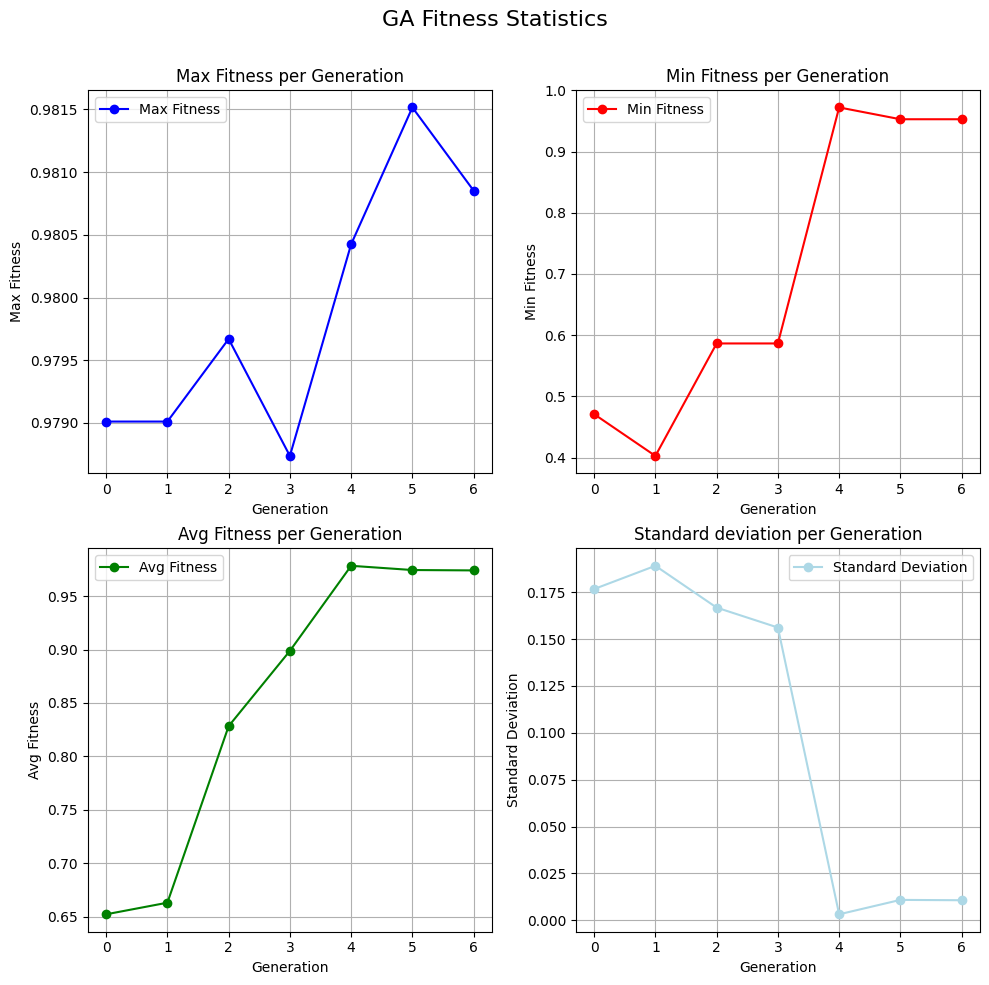

In [111]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=False)

gensGA = logbGA.select("gen")
maxGA = logbGA.select("maxGA")
avgGA = logbGA.select("avgGA")
minGA = logbGA.select("minGA")
diffGA = logbGA.select("stdGA")

axs[0][0].plot(gensGA, maxGA, marker='o', color='blue', label='Max Fitness')
axs[0][0].set_xlabel('Generation')
axs[0][0].set_ylabel('Max Fitness')
axs[0][0].set_title('Max Fitness per Generation')
axs[0][0].grid(True)
axs[0][0].legend()

axs[1][0].plot(gensGA, avgGA, marker='o', color='green', label='Avg Fitness')
axs[1][0].set_xlabel('Generation')
axs[1][0].set_ylabel('Avg Fitness')
axs[1][0].set_title('Avg Fitness per Generation')
axs[1][0].grid(True)
axs[1][0].legend()

axs[0][1].plot(gensGA, minGA, marker='o', color='red', label='Min Fitness')
axs[0][1].set_xlabel('Generation')
axs[0][1].set_ylabel('Min Fitness')
axs[0][1].set_title('Min Fitness per Generation')
axs[0][1].grid(True)
axs[0][1].legend()

axs[1][1].plot(gensGA, diffGA, marker='o', color='lightblue', label='Standard Deviation')
axs[1][1].set_xlabel('Generation')
axs[1][1].set_ylabel('Standard Deviation')
axs[1][1].set_title('Standard deviation per Generation')
axs[1][1].grid(True)
axs[1][1].legend()

plt.tight_layout()
plt.suptitle('GA Fitness Statistics', fontsize=16)
plt.subplots_adjust(top=0.9)  
plt.show()

# Implementazione Differential Evolution

### Definiamo l'algoritmo di differential evolution che farà il tuning degli iperparametri delle reti neurali


In [50]:
def setup_problem():
    if not hasattr(creator, "FitnessMax"):
        creator.create("FitnessMax", base.Fitness, weights = (1.0,))
    if not hasattr(creator, "Individual"):        
        creator.create("Individual", list, fitness = creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initCycle, creator.Individual, encoding, n = 1)
    toolbox.register("evaluate", evalFitness)

    return toolbox
def evalFitness(individual):
        # decoding 
        params = MLPC_decoding(individual)
        # costruzione e apprendimento della Rete Neurale
        mlp = MLPClassifier(hidden_layer_sizes=params["hidden_layers"], activation=params["activation"], alpha=params["alpha"], 
                            max_iter=params["max_iter"], learning_rate_init=params["learning_rate_init"], tol=params["tol"], early_stopping=True)
        mlp.fit(X_train_std, y_train)
        # validazione
        pred_val = mlp.predict(X_val_std)
        # quality measure nello spazio dei fenotipi
        report = classification_report(pred_val, y_val, zero_division=0,output_dict=True)
        f1_class0 = report['0']['f1-score']
        f1_class1 = report['1']['f1-score']
        f1_weighted = (f1_class0*nums_0 + f1_class1*nums_1)/(nums_0 + nums_1)

        # aggiunta prova per grafico 3d
        media_precision = (report['0']['precision']*nums_0 + report['1']['precision']*nums_1) / (nums_0 + nums_1)
        media_recall = (report['0']['recall']*nums_0 + report['1']['recall']*nums_1) / (nums_0 + nums_1)
        f1_nos = (2 * media_precision * media_recall) / (media_precision + media_recall)
        return f1_weighted, media_precision, media_recall, f1_nos

toolbox_problema = setup_problem()

Definiamo la funzione di mutazione per il DE che lavorerà sulle reti neurali

In [51]:
def differential_mut(gena, genb, genc, pos, F, bound_max = bound_max, bound_min = bound_min):   
    
    if type(gena) is list:    
        # 1. Scegli casualmente la lista di riferimento
        r = random.randint(1, 3)  
        ref = {1: gena, 2: genb, 3: genc}[r]
        ref_len = min(len(gena), len(genb), len(genc))  
        # 2. Troncamento o padding
        a_short = gena[:ref_len]
        b_short = genb[:ref_len]
        c_short = genc[:ref_len]

        # 3. Applichi la tua formula (es. differenza differenziale per DE)
        mutated_gene_float = list(np.array(a_short) + F*(np.array(b_short) - np.array(c_short)))
        mutated_gene = list(map(round, mutated_gene_float))
        if len(mutated_gene) != len(ref):
            # Se la lunghezza di mutated_gene non corrisponde a quella di ref, aggiungi len(ref) - len(mutated_gene) elementi da ref
            num_elements_to_add = len(ref) - len(mutated_gene)
            mutated_gene[ref_len:] = ref[-num_elements_to_add:]  
        for i in range(len(a_short)):
            if mutated_gene[i] < bound_min[pos]:
                mutated_gene[i] = min(gena[i], genb[i], genc[i])
            if mutated_gene[i] > bound_max[pos]:
                mutated_gene[i] = max(gena[i], genb[i], genc[i])
        
    else: # se il gene è un singolo valore intero
        mutated_gene = round(gena + F*(genb - genc))
        if mutated_gene < bound_min[pos]:
            mutated_gene = min(gena, genb, genc)
        if mutated_gene > bound_max[pos]:
            mutated_gene = max(gena, genb, genc)
    return mutated_gene

Definiamo il DE interno che lavorerà sulle reti neurali

In [155]:
def DEint(toolbox, CR, F, popSize, maxEvals, maxGens = None, verbose = False):
    # Liste per tracciare precision, recall, f1_nos a ogni generazione
    gen_precisions = []
    gen_recalls = []
    gen_f1s = []
    
    stats = tools.Statistics(key = lambda ind: ind.fitness.values)
    # Registriamo altri oggetti caratteristici dell'algoritmo
    def Mean(L):
        return round(np.mean(L), 10)
    def Std(L):
        return round(np.std(L), 10)
    def Min(L):
        return round(np.min(L), 10)
    def Max(L):
        return round(np.max(L), 10)
        
    stats.register("avg", Mean)
    stats.register("std", Std)
    stats.register("min", Min)
    stats.register("max", Max)
    
    halloffame = tools.HallOfFame(1)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("select", tools.selRandom, k = 3)

    logbook = tools.Logbook()
    logbook.header = "gen", "nevals", "avg", "std", "min", "max"

    pop = toolbox.population(n = popSize)

    #Valutazione della fitness degli individui della popolazione iniziale
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitness = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness):
        ind.fitness.values = fit[0],
        ind.precision = fit[1]
        ind.recall = fit[2]
        ind.f1_nos = fit[3] 
    # Salva i valori della generazione 0
    gen_precisions.append([ind.precision for ind in pop])
    gen_recalls.append([ind.recall for ind in pop])
    gen_f1s.append([ind.f1_nos for ind in pop])

    if halloffame is not None:
        halloffame.update(pop)
    rec = stats.compile(pop) if stats else {}
    logbook.record(gen = 0, nevals = len(invalid_ind) , **rec)
    if verbose:
        print(logbook.stream)
    g = 0   

    while np.sum(logbook.select("nevals")) < maxEvals:
        g += 1
        new_pop = []
        mutants = []

        for k, agent in enumerate(pop):
            a, b, c = toolbox.select(pop)
            y = toolbox.clone(agent)
            index = random.randrange(len(agent))
            for i, value in enumerate(agent):
                if i == index or random.random() < CR:
                    y[i] = differential_mut(a[i], b[i], c[i], pos = i, F = F, bound_max = bound_max, bound_min = bound_min)
            mutants.append((k, y))  # conserva l’indice per aggiornare dopo

        evaluations = toolbox.map(lambda item: toolbox.evaluate(item[1]), mutants)

        for (k, y), eva in zip(mutants, evaluations):
            y.fitness.values = eva[0],
            if y.fitness.values[0] > pop[k].fitness.values[0]:
                y.precision = eva[1]
                y.recall = eva[2]
                y.f1_nos = eva[3]
                pop[k] = y
            
        halloffame.update(pop)  
        rec = stats.compile(pop)
        logbook.record(gen = g, nevals = len(pop), **rec)
        if verbose:
            print(logbook.stream)
        # Salva i valori della generazione 0
        gen_precisions.append([ind.precision for ind in pop])
        gen_recalls.append([ind.recall for ind in pop])
        gen_f1s.append([ind.f1_nos for ind in pop])


    # Decodifica della popolazione e del miglior individuo
    decoded_pop = [MLPC_decoding(ind) for ind in pop]
    decoded_best = MLPC_decoding(halloffame[0])
    return decoded_pop, logbook, decoded_best,  halloffame[0].fitness.values[0], gen_precisions, gen_recalls, gen_f1s 


In [ ]:
"""
nel while eliminare dalle liste in poi e inserire:
 for k, agent in enumerate(pop):
            a, b, c = toolbox.select(pop)
            y = toolbox.clone(agent)
            index = random.randrange(len(agent))
            # Mutazione differenziale
            for i, value in enumerate(agent):
                if i == index or random.random() < CR:
                    y[i] = differential_mut(a[i], b[i], c[i], pos = i, F = F, bound_max = bound_max, bound_min = bound_min)
            eva = toolbox.evaluate(y) 
            y.fitness.values = eva[0], 
            if y.fitness.values[0] > agent.fitness.values[0]:
                pop[k] = y
                pop[k].precision = eva[1]
                pop[k].recall = eva[2]
                pop[k].f1_nos = eva[3]
"""

Definiamo i geni dell'individuo DE: 
- F [0, 1]
- CR [0.1, 0.9]
- popSize [10, 20]
- maxEvals [40, 200]

In [53]:
def F_encoding(min_F = 10**-1, max_F = 10**0, exp_step = 0.1):
    """
    encoding: F appartenente a range di Reali (phenotype space) --->  numero di step appartenente a sottoinsieme di Interi (genotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di encoding genera un numero naturale tra 0 ed un numero intero massimo che è determinato
    dal numero totale ammissibile di valori distinti discretizzati di F, tenendo in conto
    la restrizione data dal range [min_F, max_F] e exp_step.
    Considerando la discretizzazione lineare nella potenza di 10, questo intero corrisponde semanticamente al numero di exp_step da aggiungere
    a min_exp per ottenere l'esponente da dare a 10 per ottenere F.

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_F)
    max_exp = np.log10(max_F)
    num_step = int((max_exp - min_exp) / exp_step)
    # Estraggo il valore del gene: un valore intero randomico di step da fare
    gene_value = random.randint(0, num_step)

    return gene_value


def CR_encoding(min_CR = 0.1, max_CR = 0.9, step = 0.1):
    num_step = int((max_CR - min_CR) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def popSize_DE_encoding(min_popSize = 10, max_popSize = 20):
    popsize = random.randint(min_popSize, max_popSize)
    return popsize

def maxEvals_DE_encoding(min_maxEvals = 40, max_maxEvals = 200): 
    maxEvals = random.randint(min_maxEvals, max_maxEvals)
    return maxEvals

DE_encoding = [popSize_DE_encoding, maxEvals_DE_encoding, F_encoding, CR_encoding]

In [54]:
def F_decoding(gene_value, min_F = 10**-1, max_F = 10**0, exp_step = 0.1):
    """
    decoding: numero di step appartenente a sottoinsieme di Interi (genotype space) ---> F appartenente a range di Reali (phenotype space)
    -------------------------------------------------------------------------------------------------------------------------------------------
    La funzione di decoding assume il valore intero del gene (gene_value) e lo associa semanticamente al numero
    di exp_step che bisogna aggiungere al min_exp per ottenere l'esponente da dare a 10 per ottenere il corrispondente F.
    F = 10**(min_exp + gene_value*exp_step) -- lineare nell'esponente --

    """
    # Calcolo di esponente minimo, massimo e numero di step in questo range
    min_exp = np.log10(min_F)
    max_exp = np.log10(max_F)
    num_step = int((max_exp - min_exp) / exp_step)
    # Calcolo l'esponente da dare a 10 partendo dal valore minimo e aggiungendo ad esso un numero "gene_value" di exp_step (è lineare nell'esponente)
    esp = min_exp + gene_value*exp_step
    # Calcolo F
    F = 10**esp

    return F

def CR_decoding(gene_value, min_CR = 0.1, max_CR = 0.9, step = 0.1):
    """
    Questa funzione decodifica il gene_value in un valore di CR per l'algoritmo DE.
    CR è il tasso di crossover che controlla la probabilità di combinare i geni.
    """
    CR = min_CR + gene_value*step
    return CR

Funzione di decodifica totale del DE

In [55]:
def DE_decoding(individual):
    popsize = individual[0]
    maxevals = individual[1]
    f = F_decoding(individual[2])
    cr = CR_decoding(individual[3])
    return {
        "popSize": popsize,
        "maxEvals": maxevals,
        "F": f,
        "CR": cr
    }

## Inizializziamo gli individui "algoritmi DE" e la funzione di fitness con cui verranno valutati

In [ ]:
def setup_problem_DE():
    if not hasattr(creator, "FitnessMaxDE"):
        creator.create("FitnessMaxDE", base.Fitness, weights = (1.0,))
    if not hasattr(creator, "IndividualDE"):
        creator.create("IndividualDE", list, fitness = creator.FitnessMaxDE)

    toolbox = base.Toolbox()
    toolbox.register("individualDE", tools.initCycle, creator.IndividualDE, DE_encoding, n = 1)
    toolbox.register("evaluateDE", evalFitnessDE)

    return toolbox
def evalFitnessDE(individual):
        # decoding 
        params = DE_decoding(individual)
        runs = 3
        runs_best_fitness = []
        for run in range(runs):           
            pop, logbook, hof, hoffit, precision, recall, f1_nos = DEint(toolbox = toolbox_problema, popSize = params["popSize"], maxEvals = params["maxEvals"], 
                                              F = params["F"], CR = params["CR"])            
            runs_best_fitness.append(logbook.select("avg")[-1])
        print(runs_best_fitness)
        return np.mean(runs_best_fitness), 
toolbox_DE = setup_problem_DE()

Definiamo la funzione di mutazione che useremo nel GA esterno che lavorerà sui DE interni

In [57]:
def mutReinitDE(individual, indpb):
    """
    Mutazione che reinizializza i geni dell'individuo con nuovi valori casuali.
    """
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = DE_encoding[i]()
    return individual

# IMPLEMENTAZIONE DEL GENETICO ESTERNO (che lavora sugli individui "DE")

In [58]:
def GAextDE(toolbox = toolbox_DE , popSize = 5, CXPB = 0.7, MUTPB = 0.2, indpbMUT = 0.2 , maxEvals = 25, 
       cxFUNC = tools.cxOnePoint, indpbCX = 0.1,  mutFUNC = mutReinitDE, selFUNC = tools.selRoulette, 
       tournsize = 3, new_pop = age_based, verbose = False, maxGens = None):

    toolbox.register("map", parallel_map)

    # Registriamo altri oggetti caratteristici dell'algoritmo e non del problema
    toolbox.register("populationDE", tools.initRepeat, list, toolbox.individualDE)
    if selFUNC == tools.selTournament:
        toolbox.register("parent_selectDE", tools.selTournament, tournsize=tournsize)
    else:
        toolbox.register("parent_selectDE", selFUNC)
    if cxFUNC == tools.cxUniform:
        toolbox.register("mateDE", cxFUNC, indpb=indpbCX)
    else:
        toolbox.register("mateDE", cxFUNC)
    toolbox.register("mutateDE", mutFUNC, indpb=indpbMUT)
    toolbox.register("next_genDE", new_pop)
    # definizione statistiche
    statsDE = tools.Statistics(key = lambda ind: ind.fitness.values)
    def Mean(L):
        return round(np.mean(L), 10)
    def Std(L):
        return round(np.std(L), 10)
    def Min(L):
        return round(np.min(L), 10)
    def Max(L):
        return round(np.max(L), 10)

    statsDE.register("avgDE", Mean)
    statsDE.register("stdDE", Std)
    statsDE.register("minDE", Min)
    statsDE.register("maxDE", Max)

    halloffameDE = tools.HallOfFame(1)

    logbookDE = tools.Logbook()
    logbookDE.header = ["gen", "nevals"] + statsDE.fields

    # creazione della popolazione
    popDE = toolbox.populationDE(popSize)

    invalid_ind = [ind for ind in popDE if not ind.fitness.valid]
    fitness = toolbox.map(toolbox.evaluateDE, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness):
        ind.fitness.values = fit


    halloffameDE.update(popDE)
    recDE = statsDE.compile(popDE)
    logbookDE.record(gen = 0, nevals = len(invalid_ind) , **recDE)
    if verbose:
        print(logbookDE.stream)
    g = 0
    """
    best_fitness_ever = -np.inf
    no_improve_count = 0
    early_stop_threshold = 3
    """
    while np.sum(logbookDE.select("nevals")) < maxEvals:
        g += 1
        # Selezione della generazione successiva di genitori
        # In questo caso, la selezione dei genitori è fatta con ripetizione,
        sel_offspringDE = toolbox.parent_selectDE(popDE, len(popDE)) 
        # Clona gli individui selezionati
        offspringDE = list(map(toolbox.clone, sel_offspringDE))
        # Applicazione del crossover
        for child1, child2 in zip(offspringDE[::2], offspringDE[1::2]): 
            if random.random() < CXPB:
                toolbox.mateDE(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        # Applicazione della mutazione sugli individui figli
        for mutant in offspringDE:
            if random.random() < MUTPB:
                toolbox.mutateDE(mutant)
                del mutant.fitness.values
        # Valutazione della fitness degli individui figli
        invalid_ind = [ind for ind in offspringDE if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluateDE, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # aggiorna i valori della generazione g
        halloffameDE.update(offspringDE)
        # La popolazione viene interamente sostituita dai figli (age-based) o scelta tra gli 
        # individui con il miglior fitness
        popDE[:] = toolbox.next_genDE(offspringDE, popDE)
        # Aggiungi i valori della generazione corrente al logbook
        recDE = statsDE.compile(popDE)
        logbookDE.record(gen = g, nevals = len(invalid_ind), **recDE)
        if verbose:
            print(logbookDE.stream)
        
    # Decodifica della popolazione e del miglior individuo
    decoded_bestDE = DE_decoding(halloffameDE[0])
    decoded_popDE = [DE_decoding(ind) for ind in popDE]
    
    return decoded_popDE, logbookDE, decoded_bestDE,  halloffameDE[0].fitness.values[0], g

popsDE, logbDE, hofDE, hoffitDE, gens = GAextDE()
hofDE
print(f"Population = {popsDE}",  logbDE, f"HOF = {hofDE}", f"fitness del Best = {hoffitDE}", sep = "\n\n\n", end = "\n\n\n")


Population = [{'popSize': 16, 'maxEvals': 121, 'F': np.float64(0.5011872336272724), 'CR': 0.2}, {'popSize': 15, 'maxEvals': 121, 'F': np.float64(0.15848931924611134), 'CR': 0.2}, {'popSize': 15, 'maxEvals': 121, 'F': np.float64(0.15848931924611134), 'CR': 0.2}, {'popSize': 15, 'maxEvals': 121, 'F': np.float64(0.15848931924611134), 'CR': 0.2}, {'popSize': 15, 'maxEvals': 121, 'F': np.float64(0.15848931924611134), 'CR': 0.2}]


gen	nevals	avgDE   	stdDE     	minDE   	maxDE   
0  	5     	0.966819	0.0173442 	0.93268 	0.97827 
1  	2     	0.959272	0.0220387 	0.931909	0.97827 
2  	2     	0.967964	0.018034  	0.931909	0.977568
3  	4     	0.963349	0.0167553 	0.931909	0.978162
4  	4     	0.963895	0.00535045	0.955417	0.9711  
5  	4     	0.946625	0.0247506 	0.897737	0.962217
6  	2     	0.940694	0.0268498 	0.897737	0.963677
7  	4     	0.962675	0.0105569 	0.944782	0.977363


HOF = {'popSize': 13, 'maxEvals': 149, 'F': np.float64(0.3981071705534973), 'CR': 0.7000000000000001}


fitness del Best = 0.97

Visualizziamo un insieme di grafici per valutare l'andamento della popolazione (gli individui sono a loro volta DE) nelle generazioni

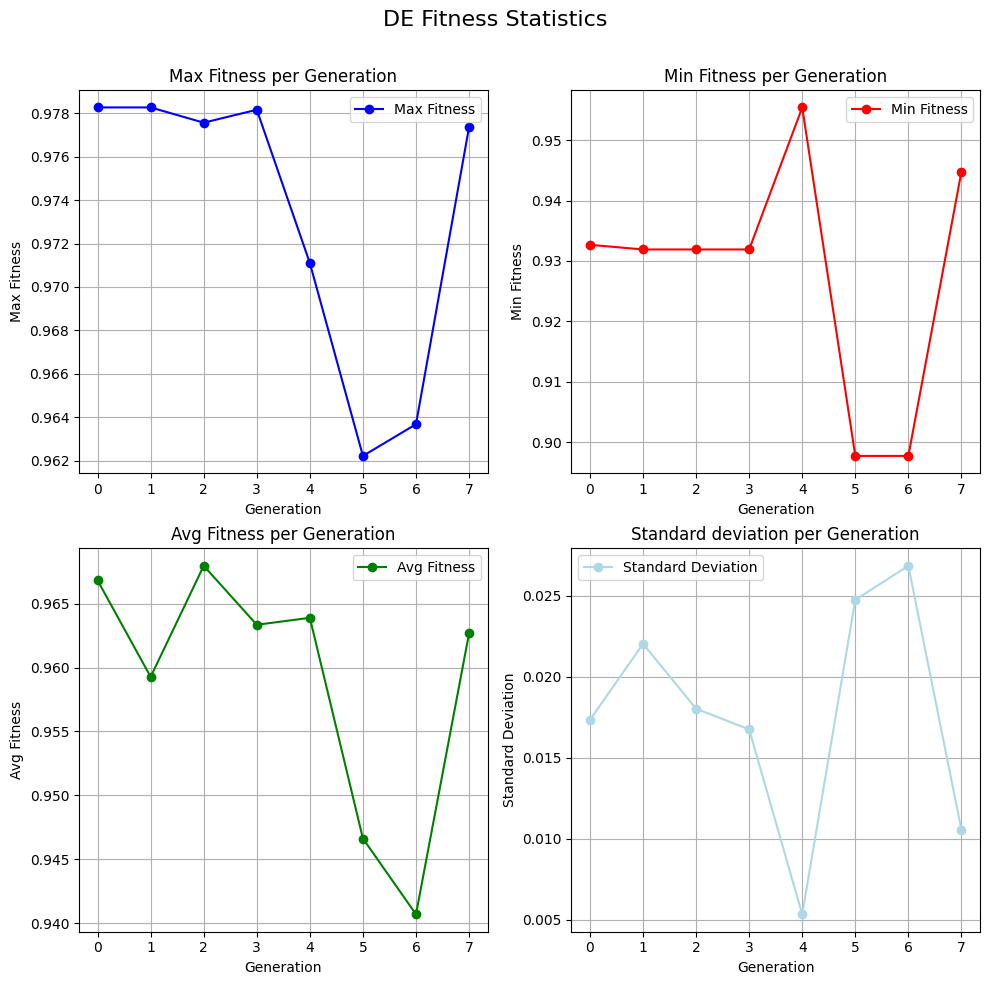

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=False)

gensDE = logbDE.select("gen")
maxDE = logbDE.select("maxDE")
avgDE = logbDE.select("avgDE")
minDE = logbDE.select("minDE")
diffDE = logbDE.select("stdDE")

axs[0][0].plot(gensDE, maxDE, marker='o', color='blue', label='Max Fitness')
axs[0][0].set_xlabel('Generation')
axs[0][0].set_ylabel('Max Fitness')
axs[0][0].set_title('Max Fitness per Generation')
axs[0][0].grid(True)
axs[0][0].legend()

axs[1][0].plot(gensDE, avgDE, marker='o', color='green', label='Avg Fitness')
axs[1][0].set_xlabel('Generation')
axs[1][0].set_ylabel('Avg Fitness')
axs[1][0].set_title('Avg Fitness per Generation')
axs[1][0].grid(True)
axs[1][0].legend()

axs[0][1].plot(gensDE, minDE, marker='o', color='red', label='Min Fitness')
axs[0][1].set_xlabel('Generation')
axs[0][1].set_ylabel('Min Fitness')
axs[0][1].set_title('Min Fitness per Generation')
axs[0][1].grid(True)
axs[0][1].legend()

axs[1][1].plot(gensDE, diffDE, marker='o', color='lightblue', label='Standard Deviation')
axs[1][1].set_xlabel('Generation')
axs[1][1].set_ylabel('Standard Deviation')
axs[1][1].set_title('Standard deviation per Generation')
axs[1][1].grid(True)
axs[1][1].legend()

plt.tight_layout()
plt.suptitle('DE Fitness Statistics', fontsize=16)
plt.subplots_adjust(top=0.9)  
plt.show()

# IMPLEMENTAZIONE DEL PARTIAL SWARM OPTIMIZATION

### Definiamo l'algoritmo di Partial Swarm Optimization che farà il tuning degli iperparametri delle reti neurali


In [ ]:
# --- DEFINIZIONE CREATOR ---
if not hasattr(creator, "FitnessMax"):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, "Particle"):
    creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, smin=None, smax=None, best = None)

C:\Users\Sasy\AppData\Roaming\Python\Python310\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Sasy\AppData\Roaming\Python\Python310\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [146]:
# --- DECODING FUNZIONI ---
def activation_decodingPSO(val):
    activations = ['identity', 'logistic', 'tanh', 'relu']
    return activations[int(val) % len(activations)]

def alpha_decodingPSO(val, min_alpha, max_alpha, step):
    exp_val = np.log10(min_alpha) + val * step
    return 10**exp_val

def learning_rate_init_decodingPSO(val, min_lri, max_lri, step):
    exp_val = np.log10(min_lri) + val * step
    return 10**exp_val

def tol_decodingPSO(val, min_tol, max_tol, step):
    exp_val = np.log10(min_tol) + val * step
    return 10**exp_val

In [156]:
def PSOint(pop_size, max_evals, w, phi1, phi2, v_max_ratio, verbose=False):
    if not hasattr(creator, "FitnessMax"):
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    if not hasattr(creator, "Particle"):
        creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, smin=None, smax=None, best = None)
    min_alpha, max_alpha, exp_step = 1e-4, 1, 0.01
    min_lri, max_lri, exp_step_lri = 1e-4, 1e-2, 0.01
    min_tol, max_tol, exp_step_tol = 1e-8, 1e-4, 0.01

    gen_precisions = []
    gen_recalls = []
    gen_f1s = []

    num_step_alpha = int((np.log10(max_alpha) - np.log10(min_alpha)) / exp_step)
    num_step_lri = int((np.log10(max_lri) - np.log10(min_lri)) / exp_step_lri)
    num_step_tol = int((np.log10(max_tol) - np.log10(min_tol)) / exp_step_tol)

    

    gene_bounds = [
        (1, 5),                   # num_layers
        (1, 10),                 # neuroni 1
        (1, 10),                 # neuroni 2
        (1, 10),                 # neuroni 3
        (1, 10),                 # neuroni 4
        (1, 10),                 # neuroni 5
        (100, 1000),              # max_iter
        (0, 3),                   # activation
        (0, num_step_alpha),      # alpha
        (0, num_step_lri),        # learning_rate_init
        (0, num_step_tol)         # tol
    ]

    smin_list = [-(high - low) * v_max_ratio for low, high in gene_bounds]
    smax_list = [(high - low) * v_max_ratio for low, high in gene_bounds]

    def generate_particle():
        pos = [random.uniform(low, high) for low, high in gene_bounds]
        part = creator.Particle(pos)
        part.speed = [random.uniform(smin, smax) for smin, smax in zip(smin_list, smax_list)]
        part.smin = smin_list
        part.smax = smax_list
        part.best = None
        return part

    def update_particle(part, best):
        u1 = (random.uniform(0, phi1) for _ in range(len(part)))
        u2 = (random.uniform(0, phi2) for _ in range(len(part)))
        v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
        v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
        part.speed = list(map(operator.add, map(operator.mul, [w]*len(part), part.speed),
                              map(operator.add, v_u1, v_u2)))
        for i, speed in enumerate(part.speed):
            if speed < part.smin[i]:
                part.speed[i] = part.smin[i]
            elif speed > part.smax[i]:
                part.speed[i] = part.smax[i]
        part[:] = list(map(operator.add, part, part.speed))

    def decode_particle(part):
        num_layers = int(round(part[0]))
        num_layers = max(1, min(5, num_layers))
        neurons = [max(1, min(10, int(round(n)))) for n in part[1:1+num_layers]]

        max_iter = int(round(part[6]))
        max_iter = max(100, min(1000, max_iter))
        activation = activation_decodingPSO(part[7])
        alpha = alpha_decodingPSO(part[8], min_alpha, max_alpha, exp_step)
        lri = learning_rate_init_decodingPSO(part[9], min_lri, max_lri, exp_step_lri)
        tol = tol_decodingPSO(part[10], min_tol, max_tol, exp_step_tol)

        return {
            "hidden_layer_sizes": tuple(neurons),
            "max_iter": max_iter,
            "activation": activation,
            "alpha": alpha,
            "learning_rate_init": lri,
            "tol": tol
        }

    def evaluate(part):
        params = decode_particle(part)
        mlp = MLPClassifier(
            hidden_layer_sizes=params["hidden_layer_sizes"],
            activation=params["activation"],
            alpha=params["alpha"],
            max_iter=params["max_iter"],
            learning_rate_init=params["learning_rate_init"],
            tol=params["tol"]
        )
        mlp.fit(X_train_std, y_train)
        pred_val = mlp.predict(X_val_std)
        report = classification_report(pred_val, y_val, output_dict=True, zero_division=0)
        f1_0 = report['0']['f1-score']
        f1_1 = report['1']['f1-score']
        media_precision = (report['0']['precision'] * nums_0 + report['1']['precision'] * nums_1) / (nums_0 + nums_1)
        media_recall = (report['0']['recall'] * nums_0 + report['1']['recall'] * nums_1) / (nums_0 + nums_1)
        f1_nos = (2 * media_precision * media_recall) / (media_precision + media_recall)
        f1_weighted = (f1_0 * nums_0 + f1_1 * nums_1) / (nums_0 + nums_1)
        return f1_weighted, media_precision, media_recall, f1_nos

    toolbox = base.Toolbox()
    toolbox.register("particle", generate_particle)
    toolbox.register("population", tools.initRepeat, list, toolbox.particle)
    toolbox.register("update", update_particle)
    toolbox.register("evaluate", evaluate)

    pop = toolbox.population(n=pop_size)
    best = None
    evals = 0

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    gen = 0
    while evals < max_evals:
        evaluations = Parallel(n_jobs=-1)(delayed(toolbox.evaluate)(part) for part in pop)
        for part, eva in zip(pop, evaluations):
            part.fitness.values = eva[0],
            part.precision = eva[1]
            part.recall = eva[2]
            part.f1_nos = eva[3]
            evals += 1
            if not part.best or part.best.fitness.values[0] < part.fitness.values[0]:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if not best or best.fitness.values[0] < part.fitness.values[0]:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
            if evals >= max_evals:
                break

        for part in pop:
            toolbox.update(part, best)

        record = stats.compile(pop)
        logbook.record(gen=gen, evals=evals, **record)
        if verbose:
            print(f"Evals: {evals}, Best Fitness: {best.fitness.values[0]}, Gen: {gen}")

        gen += 1
        gen_precisions.append([part.precision for part in pop])
        gen_recalls.append([part.recall for part in pop])
        gen_f1s.append([part.f1_nos for part in pop])
    # Decodifica popolazione e best prima di restituire
    decoded_pop = [decode_particle(ind) for ind in pop]
    decoded_best = decode_particle(best)
    best_fit = best.fitness.values[0]

    return decoded_pop, logbook, decoded_best, best_fit, gen_precisions, gen_recalls, gen_f1s

In [153]:
"""
nel while eliminare evaluation e inserire questo al posto del ciclo for:
    for part in pop:
    eva = toolbox.evaluate(part)
    part.fitness.values = eva[0],
    part.precision = eva[1] 
    part.recall = eva[2]
    part.f1_nos = eva[3]
"""

'\nnel while eliminare evaluation e inserire questo al posto del ciclo for:\n    for part in pop:\n    eva = toolbox.evaluate(part)\n    part.fitness.values = eva[0],\n    part.precision = eva[1] \n    part.recall = eva[2]\n    part.f1_nos = eva[3]\n'

### Definiamo l'algoritmo genetico ESTERNO che farà il tuning degli iperparametri del PSO


Definizione delle funzioni di encoding e decoding per trasformare gli iper-parametri del PSO interno dallo spazio del genotipo a quello del fenotipo e viceversa

Lavorando su codifica intera, andiamo a codificare tutti gli iperparametri di cui faremo il tuning.
I geni dell'individuo "PSO" e i relativi range di valori ammissibili considerati sono i seguenti:

- popSize: [10, 20]
- maxEvals: [40, 200]
- $w$ (coefficiente di inerzia): [0.4, 0.9]
- $\phi_1$ (coefficiente cognitivo): [1.5, 2.5]
- $\phi_2$ (coefficiente sociale): [1.5, 2.5]
- v_max_ratio: [0.1, 0.5]


In [136]:
def w_encoding(min_w = 0.4, max_w = 0.9, step = 0.05):
    num_step = int((max_w - min_w) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def w_decoding(gene_value, min_w = 0.4, max_w = 0.9, step = 0.05):
    """
    Questa funzione decodifica il gene_value in un valore di w per l'algoritmo PSO.
    w è il coefficiente di inerzia nella formula per aggiornare la velocità della particella.
    """
    w = min_w + gene_value*step
    return w

def phi1_encoding(min_phi1 = 1.5, max_phi1 = 2.5, step = 0.05):
    num_step = int((max_phi1 - min_phi1) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def phi1_decoding(gene_value, min_phi1 = 1.5, max_phi1 = 2.5, step = 0.05):
    """
    Questa funzione decodifica il gene_value in un valore di phi1 per l'algoritmo PSO.
    phi1 è il coefficiente cognitivo nella formula per aggiornare la velocità della particella.
    """
    phi1 = min_phi1 + gene_value*step
    return phi1

def phi2_encoding(min_phi2 = 1.5, max_phi2 = 2.5, step = 0.05):
    num_step = int((max_phi2 - min_phi2) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def phi2_decoding(gene_value, min_phi2 = 1.5, max_phi2 = 2.5, step = 0.05):
    """
    Questa funzione decodifica il gene_value in un valore di phi1 per l'algoritmo PSO.
    phi2 è il coefficiente sociale nella formula per aggiornare la velocità della particella.
    """
    phi2 = min_phi2 + gene_value*step
    return phi2

def v_max_ratio_encoding(min_vmr = 0.1, max_vmr = 0.5, step = 0.05):
    num_step = int((max_vmr - min_vmr) / step)
    gene_value = random.randint(0, num_step)
    return gene_value

def v_max_ratio_decoding(gene_value, min_vmr = 0.1, max_vmr = 0.5, step = 0.05):
    """
    Questa funzione decodifica il gene_value in un valore di v_max_ratio per l'algoritmo PSO.
    vmr è la percentuale dei range ammissibili delle componenti della posizione della particella
    da consentire come valori per le rispettive componenti della velocità.
    """
    vmr = min_vmr + gene_value*step
    return vmr


def popSize_PSO_encoding(min_popSize = 10, max_popSize = 20):
    popsize = random.randint(min_popSize, max_popSize)
    return popsize

def maxEvals_PSO_encoding(min_maxEvals = 40, max_maxEvals = 200): 
    maxEvals = random.randint(min_maxEvals, max_maxEvals)
    return maxEvals

PSO_encoding = [popSize_PSO_encoding, maxEvals_PSO_encoding, w_encoding, phi1_encoding, phi2_encoding, v_max_ratio_encoding]

Definiamo la funzione di decodifica totale

In [137]:
def PSO_decoding(individual):
    popsize = individual[0]
    maxevals = individual[1]
    w = w_decoding(individual[2])
    phi1 = phi1_decoding(individual[3])
    phi2 = phi2_decoding(individual[4])
    vmr = v_max_ratio_decoding(individual[5])
    return {
        "popSize": popsize,
        "maxEvals": maxevals,
        "W": w,
        "PHI1": phi1,
        "PHI2": phi2,
        "VMR": vmr
    }

## Inizializziamo gli individui "PSO" e la funzione di fitness con cui verranno valutati

Definiamo la funzione di mutazione che useremo nel GA esterno che lavorerà sui PSO interni

In [138]:
def mutReinitPSO(individual, indpb):
    """
    Mutazione che reinizializza i geni dell'individuo con nuovi valori casuali.
    """
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = PSO_encoding[i]()
    return individual

In [139]:
def setup_problem_PSO():
    if not hasattr(creator, "FitnessMaxPSO"):
        creator.create("FitnessMaxPSO", base.Fitness, weights = (1.0,))
    if not hasattr(creator, "IndividualPSO"):
        creator.create("IndividualPSO", list, fitness = creator.FitnessMaxPSO)

    toolbox = base.Toolbox()
    toolbox.register("individualPSO", tools.initCycle, creator.IndividualPSO, PSO_encoding, n = 1)
    toolbox.register("evaluatePSO", evalFitnessPSO)

    return toolbox
def evalFitnessPSO(individual):
        # decoding (inverse representation to create the corresponding phenotype)
        params = PSO_decoding(individual)
        runs = 3
        runs_best_fitness = []
        for run in range(runs):
            decoded_pop, logbook, decoded_best, best_fit, precision, recall, f1_nos = PSOint(pop_size = params["popSize"], max_evals = params["maxEvals"],
                                                                  w = params["W"], phi1 = params["PHI1"], phi2 = params["PHI2"], 
                                                                  v_max_ratio = params["VMR"])            
            runs_best_fitness.append(logbook.select("avg")[-1])
        print(runs_best_fitness)
        return np.mean(runs_best_fitness), 
toolbox_PSO = setup_problem_PSO()

# IMPLEMENTAZIONE DEL GENETICO ESTERNO CHE LAVORERA SUI PSO

In [ ]:
def GAextPSO(toolbox = toolbox_PSO , popSize = 5, CXPB = 0.7, MUTPB = 0.2, indpbMUT = 0.2 , maxEvals = 25, 
       cxFUNC = tools.cxOnePoint, indpbCX = 0.1,  mutFUNC = mutReinitPSO, selFUNC = tools.selRoulette, 
       tournsize = 3, new_pop = age_based, verbose = False, maxGens = None):
    
    toolbox.register("map", parallel_map)

    # Registriamo altri oggetti caratteristici dell'algoritmo e non del problema
    toolbox.register("populationPSO", tools.initRepeat, list, toolbox.individualPSO)
    if selFUNC == tools.selTournament:
        toolbox.register("parent_selectPSO", tools.selTournament, tournsize=tournsize)
    else:
        toolbox.register("parent_selectPSO", selFUNC)
    if cxFUNC == tools.cxUniform:
        toolbox.register("matePSO", cxFUNC, indpb=indpbCX)
    else:
        toolbox.register("matePSO", cxFUNC)
    toolbox.register("mutatePSO", mutFUNC, indpb=indpbMUT)
    toolbox.register("next_genPSO", new_pop)
    # definizione statistiche
    statsPSO = tools.Statistics(key = lambda ind: ind.fitness.values)
    def Mean(L):
        return round(np.mean(L), 10)
    def Std(L):
        return round(np.std(L), 10)
    def Min(L):
        return round(np.min(L), 10)
    def Max(L):
        return round(np.max(L), 10)

    statsPSO.register("avgPSO", Mean)
    statsPSO.register("stdPSO", Std)
    statsPSO.register("minPSO", Min)
    statsPSO.register("maxPSO", Max)

    halloffamePSO = tools.HallOfFame(1)

    logbookPSO = tools.Logbook()
    logbookPSO.header = ["gen", "nevals"] + statsPSO.fields

    # creazione della popolazione
    popPSO = toolbox.populationPSO(popSize)

    invalid_ind = [ind for ind in popPSO if not ind.fitness.valid]
    fitness = toolbox.map(toolbox.evaluatePSO, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness):
        ind.fitness.values = fit

    print("✓ Particle defined:", hasattr(creator, "Particle"))
    halloffamePSO.update(popPSO)
    recPSO = statsPSO.compile(popPSO)
    logbookPSO.record(gen = 0, nevals = len(invalid_ind) , **recPSO)
    if verbose:
        print(logbookPSO.stream)
    g = 0
    while np.sum(logbookPSO.select("nevals")) < maxEvals:
        g += 1
        # Select the next generation of parents. These are only links to the individuals of pop. Then, need to deep clone them to avoid changes in place
        sel_offspringPSO = toolbox.parent_selectPSO(popPSO, len(popPSO)) # selects n(=len(pop)) individuals from n with duplicates allowed
        # Clone the selected individuals
        offspringPSO = list(map(toolbox.clone, sel_offspringPSO))
        # Apply crossover on the offspring
        for child1, child2 in zip(offspringPSO[::2], offspringPSO[1::2]): # Parents early selected will be the childrens because toolbox.mate changes them in place
            if random.random() < CXPB:
                toolbox.matePSO(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        # Apply mutation on the offspring
        for mutant in offspringPSO:
            if random.random() < MUTPB:
                toolbox.mutatePSO(mutant)
                del mutant.fitness.values
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspringPSO if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluatePSO, invalid_ind)
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the halloffame with the generated individuals
        halloffamePSO.update(offspringPSO)
        # The population is entirely replaced by the offspring (age-based selection) or chosen from best fitness individuals
        popPSO[:] = toolbox.next_genPSO(offspringPSO, popPSO)
        # Append the current generation statistics to the logbook
        recPSO = statsPSO.compile(popPSO)
        logbookPSO.record(gen = g, nevals = len(invalid_ind), **recPSO)
        if verbose:
            print(logbookPSO.stream)

    # Decoding the population and the best individual
    decoded_bestPSO = PSO_decoding(halloffamePSO[0])
    decoded_popPSO = [PSO_decoding(ind) for ind in popPSO]
    
    return decoded_popPSO, logbookPSO, decoded_bestPSO,  halloffamePSO[0].fitness.values[0], g

#popsPSO, logbPSO, hofPSO, hoffitPSO, gensPSO = GAextPSO()
#hofPSO
#print(f"Population = {popsPSO}",  logbPSO, f"HOF = {hofPSO}", f"fitness del Best = {hoffitPSO}", sep = "\n\n\n", end = "\n\n\n")


✓ Particle defined: True
Population = [{'popSize': 16, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 2.45, 'PHI2': 1.9, 'VMR': 0.2}, {'popSize': 16, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 2.45, 'PHI2': 1.9, 'VMR': 0.2}, {'popSize': 16, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 1.75, 'PHI2': 1.5, 'VMR': 0.4}, {'popSize': 13, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 2.45, 'PHI2': 1.9, 'VMR': 0.2}, {'popSize': 16, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 2.45, 'PHI2': 1.9, 'VMR': 0.2}]


gen	nevals	avgPSO  	stdPSO    	minPSO  	maxPSO  
0  	5     	0.971382	0.0117004 	0.948008	0.978236
1  	1     	0.971382	0.0116945 	0.948008	0.977977
2  	5     	0.959611	0.0169269 	0.938891	0.977208
3  	4     	0.972042	0.00980671	0.952459	0.977468
4  	2     	0.977238	0.00079282	0.975908	0.978369
5  	3     	0.965694	0.0109481 	0.946771	0.977208
6  	2     	0.972332	0.00657843	0.963843	0.978194
7  	2     	0.965287	0.0136756 	0.941046	0.979129
8  	2     	0.964509	0.010199

In [ ]:
Population = [{'popSize': 16, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 2.45, 'PHI2': 1.9, 'VMR': 0.2}, {'popSize': 16, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 2.45, 'PHI2': 1.9, 'VMR': 0.2}, {'popSize': 16, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 1.75, 'PHI2': 1.5, 'VMR': 0.4}, {'popSize': 13, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 2.45, 'PHI2': 1.9, 'VMR': 0.2}, {'popSize': 16, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 2.45, 'PHI2': 1.9, 'VMR': 0.2}]


gen	nevals	avgPSO  	stdPSO    	minPSO  	maxPSO  
0  	5     	0.971382	0.0117004 	0.948008	0.978236
1  	1     	0.971382	0.0116945 	0.948008	0.977977
2  	5     	0.959611	0.0169269 	0.938891	0.977208
3  	4     	0.972042	0.00980671	0.952459	0.977468
4  	2     	0.977238	0.00079282	0.975908	0.978369
5  	3     	0.965694	0.0109481 	0.946771	0.977208
6  	2     	0.972332	0.00657843	0.963843	0.978194
7  	2     	0.965287	0.0136756 	0.941046	0.979129
8  	2     	0.964509	0.0101995 	0.947156	0.979129


HOF = {'popSize': 16, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 2.45, 'PHI2': 1.9, 'VMR': 0.2}


fitness del Best = 0.9791289761155332


In [89]:
hofPSO = {'popSize': 16, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 2.45, 'PHI2': 1.9, 'VMR': 0.2}


# Tempo di esecuzione: 161 minuti e 44.7 secondi (PD)

Visualizziamo un insieme di grafici per valutare l'andamento della popolazione (gli individui sono a loro volta genetici) nelle generazioni

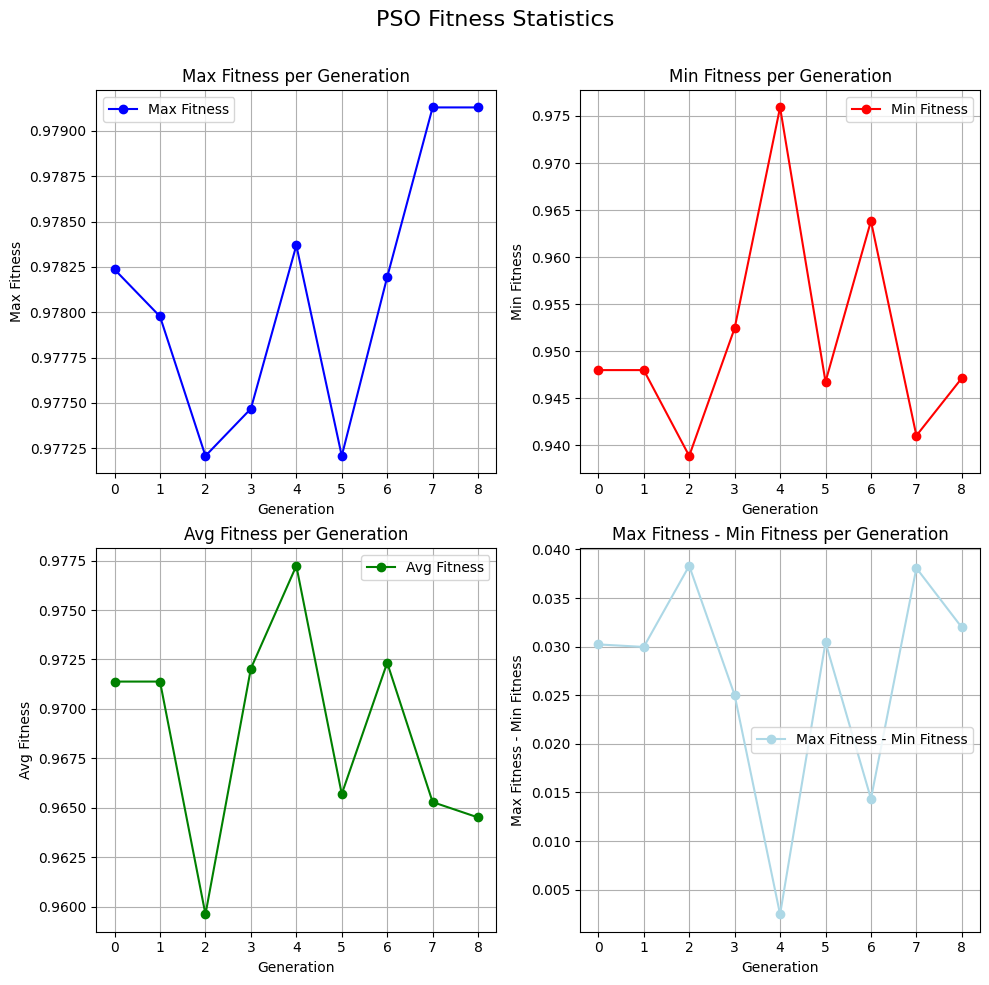

In [126]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=False)

gensPSO = logbPSO.select("gen")
maxPSO = logbPSO.select("maxPSO")
avgPSO = logbPSO.select("avgPSO")
minPSO = logbPSO.select("minPSO")
diffPSO = np.array(maxPSO) - np.array(minPSO)

axs[0][0].plot(gensPSO, maxPSO, marker='o', color='blue', label='Max Fitness')
axs[0][0].set_xlabel('Generation')
axs[0][0].set_ylabel('Max Fitness')
axs[0][0].set_title('Max Fitness per Generation')
axs[0][0].grid(True)
axs[0][0].legend()

axs[1][0].plot(gensPSO, avgPSO, marker='o', color='green', label='Avg Fitness')
axs[1][0].set_xlabel('Generation')
axs[1][0].set_ylabel('Avg Fitness')
axs[1][0].set_title('Avg Fitness per Generation')
axs[1][0].grid(True)
axs[1][0].legend()

axs[0][1].plot(gensPSO, minPSO, marker='o', color='red', label='Min Fitness')
axs[0][1].set_xlabel('Generation')
axs[0][1].set_ylabel('Min Fitness')
axs[0][1].set_title('Min Fitness per Generation')
axs[0][1].grid(True)
axs[0][1].legend()

axs[1][1].plot(gensPSO, diffPSO, marker='o', color='lightblue', label='Max Fitness - Min Fitness')
axs[1][1].set_xlabel('Generation')
axs[1][1].set_ylabel('Max Fitness - Min Fitness')
axs[1][1].set_title('Max Fitness - Min Fitness per Generation')
axs[1][1].grid(True)
axs[1][1].legend()

plt.tight_layout()
plt.suptitle('PSO Fitness Statistics', fontsize=16)
plt.subplots_adjust(top=0.9)  
plt.show()

# CONFRONTO DEI MIGLIORI EVOLUTIVI TROVATI

Riportiamo il migliore GA, il migliore DE e il migliore PSO trovati:

In [91]:
print(f"HOFGA = {hofGA}", f"HOFDE = {hofDE}", f"HOPSO = {hofPSO}", sep = "\n\n\n", end = "\n\n\n")

HOFGA = {'popSize': 14, 'CXPB': 0.2, 'MUTPB': 0.1, 'indpbMUT': 0.02, 'maxEvals': 72, 'cxFUNC': <function cxTwoPoint at 0x00000187D5987400>, 'indpbCX': 0.4, 'mutFUNC': <function mutGaussianRound at 0x00000187D7EBAB90>, 'selFUNC': <function selTournament at 0x00000187BAC19D80>, 'tournsize': 3, 'new_pop': <function fitness_based at 0x00000187D8997BE0>}


HOFDE = {'popSize': 13, 'maxEvals': 149, 'F': np.float64(0.3981071705534973), 'CR': 0.7000000000000001}


HOPSO = {'popSize': 16, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 2.45, 'PHI2': 1.9, 'VMR': 0.2}




### Definiamo una funzione per visualizzazioni animate dell'evoluzione della popolazione nel corso delle generazioni sulla superficie di fitness

In [176]:
from matplotlib import cm
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image, display

def animazione_f1_surface(gen_precisions, gen_recalls, gen_f1s, 
                          filename="evoluzione_f1.gif", use_recorded_f1=True, show_inline=True):
    """
    Crea e opzionalmente mostra un'animazione 3D dell'evoluzione degli individui in precision-recall-F1.

    Parametri:
        gen_precisions: lista di liste dei valori di precision per ogni generazione
        gen_recalls:    lista di liste dei valori di recall per ogni generazione
        gen_f1s:        lista di liste dei valori di f1 per ogni generazione (può coincidere o no con 2pr/(p+r))
        filename:       nome del file .gif da salvare
        use_recorded_f1: se True usa f1 da gen_f1s, altrimenti ricalcola F1 come 2pr/(p+r)
        show_inline:     se True, mostra la GIF nel notebook Jupyter/VSCode
    """

    # Crea la superficie teorica di F1
    precision_range = np.linspace(0.01, 1, 100)
    recall_range = np.linspace(0.01, 1, 100)
    P, R = np.meshgrid(precision_range, recall_range)
    F1_surface = 2 * P * R / (P + R)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    def update(frame):
        ax.clear()
        ax.plot_surface(P, R, F1_surface, cmap=cm.viridis, alpha=0.6)

        x_vals = gen_precisions[frame]
        y_vals = gen_recalls[frame]

        if use_recorded_f1:
            z_vals = gen_f1s[frame]
        else:
            z_vals = [2 * p * r / (p + r) if (p + r) > 0 else 0 for p, r in zip(x_vals, y_vals)]

        ax.scatter(x_vals, y_vals, z_vals, color='red', s=50, depthshade=False)

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_zlim(0, 1)
        ax.set_xlabel("Precision")
        ax.set_ylabel("Recall")
        ax.set_zlabel("F1 Score")
        ax.set_title(f"Generazione {frame}")

    ani = FuncAnimation(fig, update, frames=len(gen_precisions), interval=5000)
    ani.save(filename, writer=PillowWriter(fps=3))
    plt.close()
    print(f"Animazione salvata in {filename}")
    
    if show_inline:
        display(Image(filename=filename))

Per selezionare il migliore algoritmo evolutivo tra i tre per il nostro problema re-runniamo i tre algoritmi evolutivi inserendo come parametri i best ottenuti per avere un confronto migliore. Per effettuare una valutazione equa eseguiamo i tre algoritmi tre volte ciascuno con gli stessi valori di maxEvals, una volta con il valore di maxEvals che ha trovato il hofGA, una volta con il valore di maxEvals trovato dal hofDE e infine con quello trovato dal hofPSO.

NOTA: in questo processo di selezione del migliore tra i tre stiamo supponendo "forzatamente" che i valori degli iper-arametri maxEVals trovati dagli EA siano indipendenti dagli altri iper-parametri. Eseguire, ad esempio, il hofGA con il numero di maxEvals trovato da hofDE potrebbe portare a un risultato peggiore del GA rispetto al DE, in quanto gli altri iper-parametri del GA erano stati ottimizzati anche in funzione della dipendenza dal maxEvals del GA stesso.

## Re-run algoritmo Genetico

In [124]:
maxEvaluations = [hofGA['maxEvals'], hofDE['maxEvals'], hofPSO['maxEvals']]
runs = 3

In [152]:
fitnesses = []
for maxEv in maxEvaluations:
    fitnesses_run_GA = []
    fitnesses_run_DE = []
    fitnesses_run_PSO = []
    for run in range(runs):
        # GA
        popga, logbga, hofga, hoffitga, precisionga, recallga, f1_nosga = GAint(toolbox = toolbox_problema, 
            popSize = hofGA["popSize"], CXPB = hofGA["CXPB"], MUTPB = hofGA["MUTPB"], indpbMUT = hofGA["indpbMUT"],
            maxEvals = maxEv, cxFUNC = hofGA["cxFUNC"], indpbCX = hofGA["indpbCX"],
            mutFUNC = hofGA["mutFUNC"], selFUNC = hofGA["selFUNC"], tournsize = hofGA["tournsize"],
            new_pop = hofGA["new_pop"], verbose = False, maxGens = None)
        # DE
        popde, logbde, hofde, hoffitde, precisionde, recallde, f1_nosde = DEint(toolbox = toolbox_problema, 
            popSize = hofDE["popSize"], maxEvals = maxEv, F = hofDE["F"], CR = hofDE["CR"])
        # PSO
        poppso, logbpso, hoffipso, hoffitpso, precisionpso, recallpso, f1_nospso = PSOint(pop_size = hofPSO["popSize"],
        max_evals = maxEv, w = hofPSO["W"], phi1 = hofPSO["PHI1"], phi2 = hofPSO["PHI2"],
        v_max_ratio = hofPSO["VMR"], verbose = False)
        # Aggiungi i fitness dei migliori individui di ogni algoritmo
        fitnesses_run_GA.append(hoffitga)
        fitnesses_run_DE.append(hoffitde)
        fitnesses_run_PSO.append(hoffitpso) 
    # Aggiungi la media dei fitness dei migliori individui di ogni algoritmo    
    fitnesses.append(np.mean(fitnesses_run_GA))
    fitnesses.append(np.mean(fitnesses_run_DE))
    fitnesses.append(np.mean(fitnesses_run_PSO))

C:\Users\Sasy\AppData\Roaming\Python\Python310\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Sasy\AppData\Roaming\Python\Python310\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Sasy\AppData\Roaming\Python\Python310\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Sasy\AppData\Roaming\Python\Python310\site-packages\de

Animazione salvata in evoluzione_GA.gif


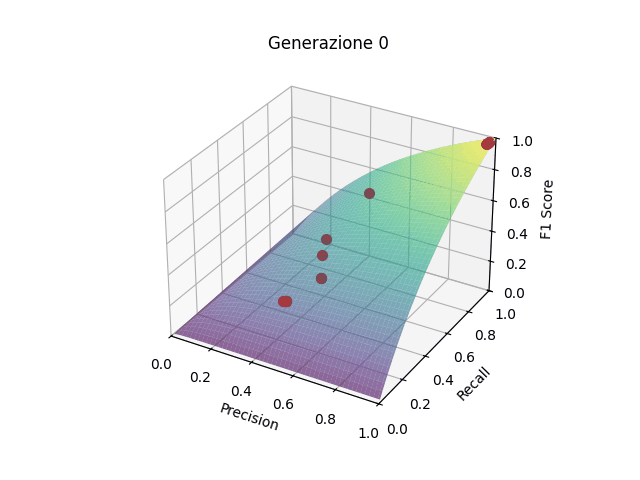

In [177]:
animazione_f1_surface(precisionga, recallga, f1_nosga, 
                          filename="evoluzione_GA.gif", use_recorded_f1=True, show_inline=True)


Animazione salvata in evoluzione_DE.gif


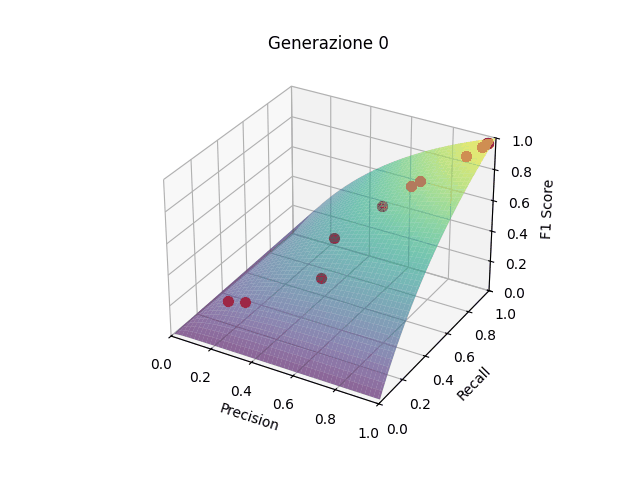

In [194]:
from IPython.display import HTML

anim = animazione_f1_surface(precisionde, recallde, f1_nosde,
                          filename="evoluzione_DE.gif", use_recorded_f1=True, show_inline=True)
#HTML(anim.to_jshtml())

Animazione salvata in evoluzione_PSO.gif


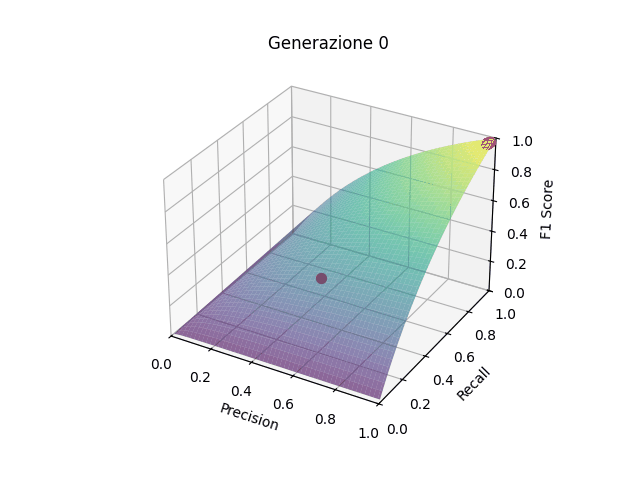

In [ ]:
animazione_f1_surface(precisionpso, recallpso, f1_nospso, 
                          filename="evoluzione_PSO.gif", use_recorded_f1=True, show_inline=True)
    

### Confrontiamo i tre hof con un barplot

NOTA: sulle ascisse i valori di maxEvals non saranno necessariamente in ordine crescente. Il primo valore sarà il maxEvals del hofGA, il secondo sarà quello del hofDE, il terzo sarà quello del hofPSO.

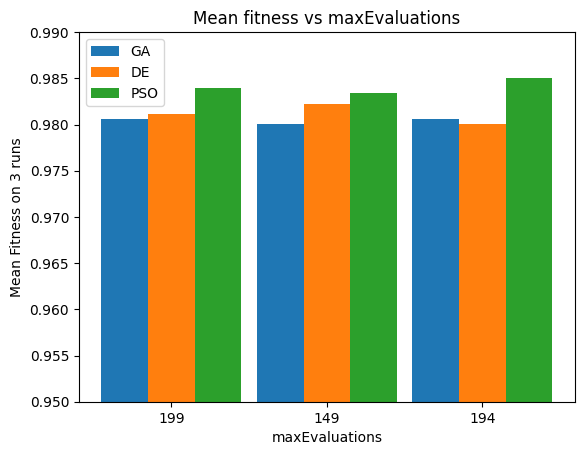

In [229]:
positions = np.arange(0, len(maxEvaluations) * 2, 2)
labels = maxEvaluations
width = 0.6

rects1 = plt.bar(positions - width, fitnesses[0::3], width, label = "GA" )
rects2 = plt.bar(positions, fitnesses[1::3], width, label = "DE")
rects2 = plt.bar(positions + width,  fitnesses[2::3], width, label = "PSO")


plt.gca().set_ylabel(f"Mean Fitness on {runs} runs")
plt.gca().set_xlabel("maxEvaluations")
plt.gca().set_title("Mean fitness vs maxEvaluations")
plt.gca().set_xticks(positions)
plt.gca().set_ylim(0.95, 0.99)
plt.gca().set_xticklabels(labels)
plt.legend()
plt.show()

# Il migliore EA trovato è il seguente:

In [220]:
import copy

bestf1_ind = fitnesses.index(max(fitnesses))
bestEA = copy.deepcopy([hofGA, hofDE, hofPSO][bestf1_ind % 3])
bestEA["maxEvals"] = maxEvaluations[bestf1_ind // 3]

print(f"Il migliore EA trovato è: \n{bestEA = }")

Il migliore EA trovato è: 
bestEA = {'popSize': 16, 'maxEvals': 194, 'W': 0.7000000000000001, 'PHI1': 2.45, 'PHI2': 1.9, 'VMR': 0.2}


Il migliore EA è il PSO con maxEvals = 194. Tuttavia, il tempo di esecuzione dei PSO è più alto di circa un fattore 10 rispetto ai GA e i DE, per questo motivo scegliamo di selezionare il migliore EA tra i GA e i DE, escludendo i PSO.

In [ ]:
# Indici da escludere (3,6,9 in base 1, quindi 2,5,8 in base 0)
indici_da_escludere = {2, 5, 8}

# Costruisco una nuova lista escludendo quegli indici
fitnesses_wPSO = [elem for i, elem in enumerate(fitnesses) if i not in indici_da_escludere]
bestf1_ind_wPSO = fitnesses_wPSO.index(max(fitnesses_wPSO))
bestEA_wPSO = copy.deepcopy([hofGA, hofDE][bestf1_ind_wPSO % 2])
bestEA_wPSO["maxEvals"] = maxEvaluations[bestf1_ind_wPSO // 2]

print(f"Il migliore EA trovato è il seguente Differential Evolution: \n{bestEA_wPSO = }")

Il migliore EA trovato è il seguente Differential Evolution: 
bestEA_wPSO = {'popSize': 13, 'maxEvals': 149, 'F': np.float64(0.3981071705534973), 'CR': 0.7000000000000001}
149


### Lo lanciamo un'ultima volta per estrarre la rete neurale

In [235]:
popbest, logbbest, hofbest, hoffitbest, precisionbest, recallbest, f1_nosbest = DEint(toolbox = toolbox_problema, 
            popSize = bestEA_wPSO["popSize"], maxEvals = bestEA_wPSO["maxEvals"], F = bestEA_wPSO["F"], CR = bestEA_wPSO["CR"])

In [242]:
print(f"La rete neurale migliore è: {hofbest}", f"Il suo F1_weighted è: {hoffitbest}", sep= "\n", end = "\n")

La rete neurale migliore è: {'hidden_layers': [4, 10, 2], 'max_iter': 1391, 'activation': 'tanh', 'alpha': np.float64(0.0007943282347242822), 'learning_rate_init': np.float64(0.06309573444801943), 'tol': np.float64(2.511886431509582e-08)}
Il suo F1_weighted è: 0.9817173132153402


### Costruzione, apprendimento della rete

In [ ]:
mlpbest = MLPClassifier(hidden_layer_sizes = hofbest["hidden_layers"], max_iter = hofbest["max_iter"], activation=hofbest["activation"], 
                        alpha=hofbest["alpha"],  learning_rate_init=hofbest["learning_rate_init"], tol= hofbest["tol"], verbose = True, early_stopping=True)

mlpbest.fit(X_train_std, y_train)



Iteration 1, loss = 0.48286780
Validation score: 0.970954
Iteration 2, loss = 0.14308083
Validation score: 0.979253
Iteration 3, loss = 0.08925386
Validation score: 0.979253
Iteration 4, loss = 0.07875248
Validation score: 0.975104
Iteration 5, loss = 0.07382860
Validation score: 0.983402
Iteration 6, loss = 0.07203885
Validation score: 0.979253
Iteration 7, loss = 0.07311202
Validation score: 0.975104
Iteration 8, loss = 0.07642327
Validation score: 0.979253
Iteration 9, loss = 0.06948043
Validation score: 0.979253
Iteration 10, loss = 0.06293351
Validation score: 0.979253
Iteration 11, loss = 0.07017445
Validation score: 0.979253
Iteration 12, loss = 0.09320362
Validation score: 0.975104
Iteration 13, loss = 0.07411865
Validation score: 0.975104
Iteration 14, loss = 0.06103034
Validation score: 0.970954
Iteration 15, loss = 0.06042909
Validation score: 0.979253
Iteration 16, loss = 0.06096242
Validation score: 0.979253
Validation score did not improve more than tol=0.000000 for 10 co

### Predict sui dati di test

In [446]:
pred_valbest = mlpbest.predict(X_val_std)
cbest = confusion_matrix(pred_valbest, y_val)
reportbest = classification_report(pred_valbest, y_val, zero_division=0, output_dict=True)
reportbest1 = classification_report(pred_valbest, y_val, zero_division=0)

print(reportbest1)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       335
           1       0.97      0.98      0.98       267

    accuracy                           0.98       602
   macro avg       0.98      0.98      0.98       602
weighted avg       0.98      0.98      0.98       602



In [447]:

f1_class0best = reportbest["0"]["f1-score"]
f1_class1best = reportbest["1"]["f1-score"]
print("")
f1_weighted = (f1_class0best*nums_0 + f1_class1best*nums_1)/(nums_0 + nums_1)
f1_weighted

np.float64(0.9800590963657055)

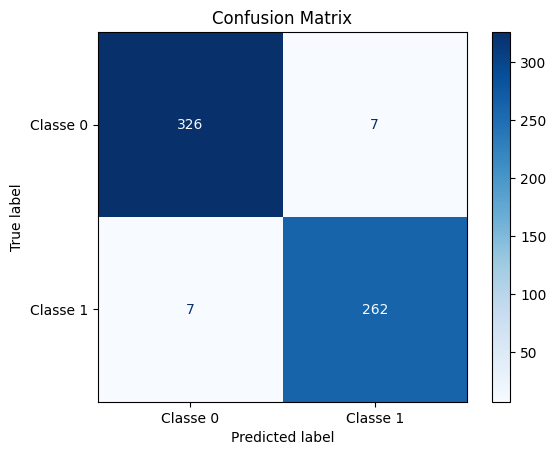

In [443]:
from sklearn.metrics import ConfusionMatrixDisplay


labels = ['Classe 0', 'Classe 1']


disp = ConfusionMatrixDisplay(confusion_matrix=cbest, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


# CONCLUSIONI

Il migliore EA per il nostro prolema, tenendo conto anche del tempo di esecuzione, è un Differential Evolution

La migliore rete neurale trovata da esso ha restituito un valore di F1 pesato sui dati di test di 0.9800590963657055